# *dandelion* Notebook-3
![dandelion_logo](img/dandelion_logo.png)

# BCR clustering and visualization

Now that we have both 1) a pre-processed BCR data and 2) matching `AnnData` object, we can start finding clones and *'integrate'* the results. All the BCR analyses files can be saved remain accessible externally in *.tsv* format so that it can be used in other tools like *immcantation*, *immunoarch*, *vdjtools*, *bcrep* etc., and only a few items will be added to the `AnnData` object, mainly for visualization purposes.

On the topic of finding clones, there are many ways used for identifying BCR clones, almost all involving some measure based on sequence similarity. There are also a lot of very well established guidelines and criterias maintained by the BCR community. For example, *immcantation* uses a number of model-based [methods](https://changeo.readthedocs.io/en/stable/methods/clustering.html) to group clones based on the distribution of length-normalised junctional hamming distance while [rbr1](https://www.well.ox.ac.uk/research/research-groups/bashford-rogers) developed a method to use the whole BCR VDJ sequence to define clones as shown in this recent [paper](https://www.nature.com/articles/s41586-019-1595-3.pdf). While these methods have mainly been applied to bulk BCR-seq protocols, they are biological grounded and should be applicable to single cells, as shown in immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html).

# Finding clones

The following is *dandelion*'s implementation of a rather conventional method to define clones, `tl.find_clones`. 

Clone definition is based on the following criterias:

    (1) Identical IGH V-J gene usage.

    (2) Identical junctional sequence length.

    (3) Junctional sequences attains a minimum of % sequence similarity, based on hamming distance. The similarity cut-off is tunable (default is 85%).

    (4) Light chain usage. If cells within clones use different light chains, the clone will be splitted following the same conditions for heavy chains in (1-3) as above. 

The 'clone_id' name follows a `{A}_{B}_{C}_{D}` format and largely reflects the conditions above where:

    {A} indicates if the contigs use the same IGH V/J genes.
    
    {B} indicates if IGH junctional sequences are equal in length.
    
    {C} indicates if clones are splitted based on junctional hamming distance threshold
    
    {D} indicates light chain pairing. 

The last position will not be annotated if there's only one group of light chains usage detected in the clone.

So in essence, cloned flagged up in `{A}` through to `{D}` are evolutionary-related and those that actually encode productive chains in `{D}` (or `{C}`) would be functionally related.

#### Import modules

In [1]:
import os
import pandas as pd
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion'))
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/PIP/'))
# I'm importing scanpy here to make use of its logging module.
import scanpy as sc
sc.settings.verbosity = 3

/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


I will work with the same example from the previous notebook since I have the `AnnData` object saved and vdj table filtered.

#### Set up some variables

In [2]:
sample = 'Pan_T7918901'
bcr_folder = 'Pan_Immune_BCR/'
gex_folder = 'Pan_Immune_GEX/'
sampledict = ddl.utl.dict_from_table('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/dandelion_files/meta/PIP_sampleInfo_kt16.txt', columns = ('SANGER SAMPLE ID', 'GEX_SAMPLE_ID')) 
filtered_file = bcr_folder+sample+'/dandelion/data/all_contig_igblast_gap_genotyped_filtered.tsv'

## Running `tl.find_clones`
The function will take a file path, a pandas `DataFrame` (for example if you've used pandas to read in the filtered file already), or a `Dandelion` class object (described in next section). The default mode for calculation of junctional hamming distance is to use the junction amino acid sequences. If you want to do it via nucleotide, you can specify the option:
```python
clustering_by = 'nt'
```

If you want to use the alleles for defining V-J gene usuage, specify:
```python
by_alleles = True
```

In [3]:
results = ddl.tl.find_clones(filtered_file)

Finding clones


Finding clones based on heavy chains : 100%|██████████| 71/71 [00:00<00:00, 8739.42it/s]
Refining clone assignment based on light chain pairing : 100%|██████████| 90/90 [00:00<00:00, 1056.67it/s]


 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:00)


This will return a new column with the column name `'clone_id'` as per convention. If a filepath is provided as input, it will also save the file automatically into the base directory of the file name. Otherwise, if `Dandelion` object or pandas `DataFrame` is provided, the option `write_out` (default is `False`) will toggle whether to write the file and `outdir` and `outFilePrefix` will handle the out file directory and out file prefix respectively.

## Alternative : Running `tl.define_clones`

Alternatively, a wrapper to call *changeo's* `DefineClones.py` is also included. To run it, you need to choose the distance threshold for clonal assignment. To facilitate this, the function `tl.calculate_threshold` will run [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) function and return a plot showing the length normalized hamming distance distribution and automated threshold value. Again, `tl.calculate_threshold` will take a file path, pandas `DataFrame` or `Dandelion` object as input. If a dandelion object is provided, the threshold value will be inserted into the `.threshold` slot. We will provide a copy of the object so that it doesn't overwrite the `clone_id` column from the step above.

### *tl.calculate_threshold*

Calculating threshold


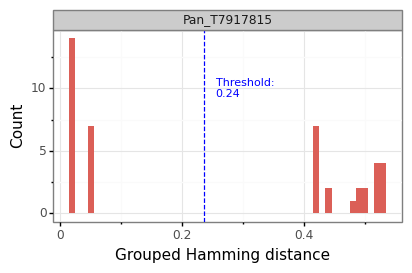

<ggplot: (316079601)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:00:07)


In [4]:
results_x = results.copy()
ddl.tl.calculate_threshold(results_x) # TODO: check if this function works on a table containing multiple samples.

In [5]:
# see the actual value in .threshold slot
results_x.threshold

0.2351300509492626

The results return says that the automated threshold is at the blue line but you can also use other values as long as you can justify it. You can use the same function to visualise a manual threshold value:

Calculating threshold


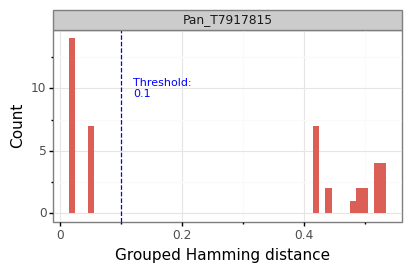

<ggplot: (322438865)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:00:05)


In [6]:
ddl.tl.calculate_threshold(results_x, manual_threshold = 0.1)

In [7]:
# see the updated .threshold slot
results_x.threshold

0.1

### *tl.define_clones*

Now we can run `tl.define_clones` to call *changeo's* `DefineClones.py`; see [here](https://changeo.readthedocs.io/en/stable/methods/clustering.html) for more info. Note, if a pandas `DataFrame` or file path is provided as the input, the value in dist option (corresponds to threshold value) needs to be manually supplied. If a `Dandelion` object is provided, it will automatically retrieve it from the relevant slot. Note that this overwrites the `clone_id` column so stash that column or provide a copy of the object like what I did above.

In [8]:
ddl.tl.define_clones(results_x)

Finding clones
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:03)


### *Dandelion* class
You can see that the objects returned via the functions above are `Dandelion` objects, which is a python class holding the data:

In [9]:
results

Dandelion class object with n_obs = 243 and n_contigs = 468
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support', 'v_id

Essentially, the data slot holds the airr/changeo contig table while the metadata holds a collapsed version that is compatible with combining with `AnnData`'s `.obs` slot. The other slots will be gradually filled as we go through the notebook. You can retrieve these slots like a typical class object; for example, if I want the metadata:

In [10]:
results.metadata

sample_id clone_id clone_group_id isotype  \
cell_id                                                                       
Pan_T7917815_ACCTTTATCGCTTGTC  Pan_T7917815   35_1_1             35     IgG   
Pan_T7917815_ACTGCTCCAGGTCGTC  Pan_T7917815   29_1_1             29     IgM   
Pan_T7917815_CCTACCAGTGCCTTGG  Pan_T7917815   64_4_1             64     IgG   
Pan_T7917815_CGATCGGAGGGCTCTC  Pan_T7917815   25_1_1             25     IgG   
Pan_T7917815_CGGACGTTCTTTAGGG  Pan_T7917815   62_1_1             62     IgG   
...                                     ...      ...            ...     ...   
Pan_T7917815_GCAGCCAAGTATTGGA  Pan_T7917815   66_1_1             66     IgG   
Pan_T7917815_GTACTCCGTAGTAGTA  Pan_T7917815    4_1_1              4     NaN   
Pan_T7917815_TTGCCGTCAAGTCTGT  Pan_T7917815   44_2_1             44     IgA   
Pan_T7917815_GTACTCCAGCCACTAT  Pan_T7917815   29_2_1             29     IgG   
Pan_T7917815_TTAGGACCACCAGGCT  Pan_T7917815   13_1_1             13     IgG   

                              lightchain     status  \
cell_id                                               
Pan_T7917815_ACCTTTATCGCTTGTC        IgK  IGH + IGK   
Pan_T7917815_ACTGCTCCAGGTCGTC        IgK  IGH + IGK   
Pan_T7917815_CCTACCAGTGCCTTGG        IgK  IGH + IGK   
Pan_T7917815_CGATCGGAGGGCTCTC        IgK  IGH + IGK   
Pan_T7917815_CGGACGTTCTTTAGGG        IgK  IGH + IGK   
...                                  ...        ...   
Pan_T7917815_GCAGCCAAGTATTGGA        IgK  IGH + IGK   
Pan_T7917815_GTACTCCGTAGTAGTA        IgL  IGH + IGL   
Pan_T7917815_TTGCCGTCAAGTCTGT        IgK  IGH + IGK   
Pan_T7917815_GTACTCCAGCCACTAT        IgK  IGH + IGK   
Pan_T7917815_TTAGGACCACCAGGCT        IgK  IGH + IGK   

                                                vdj_status productive  \
cell_id                                                                 
Pan_T7917815_ACCTTTATCGCTTGTC                Multi_heavy_v          T   
Pan_T7917815_ACTGCTCCAGGTCGTC                       Single          T   
Pan_T7917815_CCTACCAGTGCCTTGG                       Single          T   
Pan_T7917815_CGATCGGAGGGCTCTC                Multi_heavy_v          T   
Pan_T7917815_CGGACGTTCTTTAGGG  Multi_light_v,Multi_light_j          T   
...                                                    ...        ...   
Pan_T7917815_GCAGCCAAGTATTGGA                       Single          T   
Pan_T7917815_GTACTCCGTAGTAGTA                       Single          T   
Pan_T7917815_TTGCCGTCAAGTCTGT                       Single          T   
Pan_T7917815_GTACTCCAGCCACTAT  Multi_light_v,Multi_light_j          T   
Pan_T7917815_TTAGGACCACCAGGCT                       Single          T   

                              umi_counts_heavy umi_counts_light  \
cell_id                                                           
Pan_T7917815_ACCTTTATCGCTTGTC                2               42   
Pan_T7917815_ACTGCTCCAGGTCGTC               20              102   
Pan_T7917815_CCTACCAGTGCCTTGG              143              422   
Pan_T7917815_CGATCGGAGGGCTCTC              113              622   
Pan_T7917815_CGGACGTTCTTTAGGG                3               35   
...                                        ...              ...   
Pan_T7917815_GCAGCCAAGTATTGGA                3              169   
Pan_T7917815_GTACTCCGTAGTAGTA               29               31   
Pan_T7917815_TTGCCGTCAAGTCTGT               53              272   
Pan_T7917815_GTACTCCAGCCACTAT               23              188   
Pan_T7917815_TTAGGACCACCAGGCT               21              232   

                                     v_call_heavy        v_call_light  \
cell_id                                                                 
Pan_T7917815_ACCTTTATCGCTTGTC   IGHV3-21,IGHV3-30           IGKV1D-12   
Pan_T7917815_ACTGCTCCAGGTCGTC            IGHV3-21            IGKV3-20   
Pan_T7917815_CCTACCAGTGCCTTGG            IGHV4-34            IGKV3-11   
Pan_T7917815_CGATCGGAGGGCTCTC  IGHV1-69,IGHV1-69D            IGKV3-20   
Pan_T7917815_CGGACGTTCTTTAGGG 

You can deep copy the `Dandelion` object to another variable which will inherit all slots:

In [11]:
results2 = results.copy()
results2.metadata

sample_id clone_id clone_group_id isotype  \
cell_id                                                                       
Pan_T7917815_ACCTTTATCGCTTGTC  Pan_T7917815   35_1_1             35     IgG   
Pan_T7917815_ACTGCTCCAGGTCGTC  Pan_T7917815   29_1_1             29     IgM   
Pan_T7917815_CCTACCAGTGCCTTGG  Pan_T7917815   64_4_1             64     IgG   
Pan_T7917815_CGATCGGAGGGCTCTC  Pan_T7917815   25_1_1             25     IgG   
Pan_T7917815_CGGACGTTCTTTAGGG  Pan_T7917815   62_1_1             62     IgG   
...                                     ...      ...            ...     ...   
Pan_T7917815_GCAGCCAAGTATTGGA  Pan_T7917815   66_1_1             66     IgG   
Pan_T7917815_GTACTCCGTAGTAGTA  Pan_T7917815    4_1_1              4     NaN   
Pan_T7917815_TTGCCGTCAAGTCTGT  Pan_T7917815   44_2_1             44     IgA   
Pan_T7917815_GTACTCCAGCCACTAT  Pan_T7917815   29_2_1             29     IgG   
Pan_T7917815_TTAGGACCACCAGGCT  Pan_T7917815   13_1_1             13     IgG   

                              lightchain     status  \
cell_id                                               
Pan_T7917815_ACCTTTATCGCTTGTC        IgK  IGH + IGK   
Pan_T7917815_ACTGCTCCAGGTCGTC        IgK  IGH + IGK   
Pan_T7917815_CCTACCAGTGCCTTGG        IgK  IGH + IGK   
Pan_T7917815_CGATCGGAGGGCTCTC        IgK  IGH + IGK   
Pan_T7917815_CGGACGTTCTTTAGGG        IgK  IGH + IGK   
...                                  ...        ...   
Pan_T7917815_GCAGCCAAGTATTGGA        IgK  IGH + IGK   
Pan_T7917815_GTACTCCGTAGTAGTA        IgL  IGH + IGL   
Pan_T7917815_TTGCCGTCAAGTCTGT        IgK  IGH + IGK   
Pan_T7917815_GTACTCCAGCCACTAT        IgK  IGH + IGK   
Pan_T7917815_TTAGGACCACCAGGCT        IgK  IGH + IGK   

                                                vdj_status productive  \
cell_id                                                                 
Pan_T7917815_ACCTTTATCGCTTGTC                Multi_heavy_v          T   
Pan_T7917815_ACTGCTCCAGGTCGTC                       Single          T   
Pan_T7917815_CCTACCAGTGCCTTGG                       Single          T   
Pan_T7917815_CGATCGGAGGGCTCTC                Multi_heavy_v          T   
Pan_T7917815_CGGACGTTCTTTAGGG  Multi_light_v,Multi_light_j          T   
...                                                    ...        ...   
Pan_T7917815_GCAGCCAAGTATTGGA                       Single          T   
Pan_T7917815_GTACTCCGTAGTAGTA                       Single          T   
Pan_T7917815_TTGCCGTCAAGTCTGT                       Single          T   
Pan_T7917815_GTACTCCAGCCACTAT  Multi_light_v,Multi_light_j          T   
Pan_T7917815_TTAGGACCACCAGGCT                       Single          T   

                              umi_counts_heavy umi_counts_light  \
cell_id                                                           
Pan_T7917815_ACCTTTATCGCTTGTC                2               42   
Pan_T7917815_ACTGCTCCAGGTCGTC               20              102   
Pan_T7917815_CCTACCAGTGCCTTGG              143              422   
Pan_T7917815_CGATCGGAGGGCTCTC              113              622   
Pan_T7917815_CGGACGTTCTTTAGGG                3               35   
...                                        ...              ...   
Pan_T7917815_GCAGCCAAGTATTGGA                3              169   
Pan_T7917815_GTACTCCGTAGTAGTA               29               31   
Pan_T7917815_TTGCCGTCAAGTCTGT               53              272   
Pan_T7917815_GTACTCCAGCCACTAT               23              188   
Pan_T7917815_TTAGGACCACCAGGCT               21              232   

                                     v_call_heavy        v_call_light  \
cell_id                                                                 
Pan_T7917815_ACCTTTATCGCTTGTC   IGHV3-21,IGHV3-30           IGKV1D-12   
Pan_T7917815_ACTGCTCCAGGTCGTC            IGHV3-21            IGKV3-20   
Pan_T7917815_CCTACCAGTGCCTTGG            IGHV4-34            IGKV3-11   
Pan_T7917815_CGATCGGAGGGCTCTC  IGHV1-69,IGHV1-69D            IGKV3-20   
Pan_T7917815_CGGACGTTCTTTAGGG 

The `Dandelion` class also contains save/load methods to facilitate the storage/usage of the data.

In [12]:
results.save('Pan_immune_BCR/Pan_T7918901/dandelion/data/dandelion_results.pkl')

If you want to load in in the future, there's a number of ways to do it. For example, you can create an empty `Dandelion` class object and then run `object.load('path/to/file.pkl')` or call it from the utility module:

In [13]:
results3 = ddl.utl.Dandelion.load('Pan_immune_BCR/Pan_T7918901/dandelion/data/dandelion_results.pkl')
results3.data

sequence_id  \
sequence_id                                                                          
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1  Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1   
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2  Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1  Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2  Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2   
Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1  Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1   
...                                                                            ...   
Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2  Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1  Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2  Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2   
Pan_T7917815_TTAGGACCACCAGGCT-1_contig_1  Pan_T7917815_TTAGGACCACCAGGCT-1_contig_1   
Pan_T7917815_TTAGGACCACCAGGCT-1_contig_2  Pan_T7917815_TTAGGACCACCAGGCT-1_contig_2   

                                                                                   sequence  \
sequence_id                                                                                   
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1  GAGGAGTCAGACCCAGTCAGGACACAGCATGGACATGAGGGTCCCC...   
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2  AGCCTGCGAGGCGAAGATACGGCTATCTATTACTGTGCGAGTGATC...   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1  TGGGGGAGAAGAGCTGCTCAGTTAGGACCCAGAGGGAACCATGGAA...   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2  GAGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCA...   
Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1  AGAGAGCCCTGGGGAGGAACTGCTCAGTTAGGACCCAGAGGGAACC...   
...                                                                                     ...   
Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2  GGCAGAAGTCTCTCTCAGTCAGGACACAGCATGGACATGAGGGTCC...   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1  GGACACCCTGTGCAGGAGTCAGACCCAGTCAGGACACAGCATGGAC...   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2  GAGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCA...   
Pan_T7917815_TTAGGACCACCAGGCT-1_contig_1  GGGAGAAGAGCTGCTCAGTAAGGACCCAGAGGGAACCATGGAAACC...   
Pan_T7917815_TTAGGACCACCAGGCT-1_contig_2  GATACTTTCTGAGACTCATGGACCTCCTGCACAAGAACATGAAACA...   

                                         rev_comp productive  \
sequence_id                                                    
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1        F          T   
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2        F          T   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1        F          T   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2        F          T   
Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1        F          T   
...                                           ...        ...   
Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2        F          T   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1        F          T   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2        F          T   
Pan_T7917815_TTAGGACCACCAGGCT-1_contig_1        F          T   
Pan_T7917815_TTAGGACCACCAGGCT-1_contig_2        F          T   

                                                                        v_call  \
sequence_id                                                                      
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_1                          IGKV1D-12*01   
Pan_T7917815_ACCTTTATCGCTTGTC-1_contig_2   IGHV3-21*06,IGHV3-30*07,IGHV3-30*12   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_1                           IGKV3-20*01   
Pan_T7917815_ACTGCTCCAGGTCGTC-1_contig_2                           IGHV3-21*01   
Pan_T7917815_CCTACCAGTGCCTTGG-1_contig_1                           IGKV3-11*01   
...                                                                        ...   
Pan_T7917815_TTGCCGTCAAGTCTGT-1_contig_2                           IGKV1-27*01   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_1  IGKV1-12*01,IGKV1-12*02,IGKV1D-12*02   
Pan_T7917815_GTACTCCAGCCACTAT-1_contig_2                       

## Visualization of BCR network
*dandelion* provides a network-style approach for visualisation of results. This uses the full V(D)J contig sequences instead of just the junctional sequences to chart a tree-like network for each clone.

### Generate network
### *tl.generate_network*
First we need to generate the network. The tool function `tl.generate_network` will take a V(D)J table that has clones defined, specifically under the `'clone_id'` column. 

Again, the default mode is the use of ammino acid sequences which can be toggled to using nucleotide sequences with:
```python
distance_mode = 'nt'
```

If you have a pre-processed table parsed from immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html), or any other method as long as it's in a *changeo/airr tsv* format, the table can be used as well. The main option to consider adjusting here is the `clones_sep` option; this decides how the *'grouping'* of the clones would be performed during network construction. I'm expecting the clone to be annotated with some sort of separator, such as `_`, and the `clones_sep` option takes a tuple for the position (`int`) to return after split the clone name and the type of separator (`str`), in the following format:
```python
clones_sep = (int, str)
```

So for example, if my clone is called `21-A`, then the tuple to provide to `clones_sep` would be:
```python
clones_sep = (0, '-')
```

If no appropriate separators are found, it will not split the `clone_id` column and will just duplicate it in the new `clone_group` column in the metadata.

In [14]:
ddl.tl.generate_network(results)

Generating network


Linking edges : 100%|██████████| 100/100 [00:00<00:00, 630.85it/s]


 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
   'distance', heavy and light chain distance matrices
   'edges', network edges
   'layout', network layout
   'graph', network (0:00:05)


##### check the newly re-initialized Dandelion object

In [15]:
results

Dandelion class object with n_obs = 243 and n_contigs = 468
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support', 'v_id

## Visualizing BCR network - Part 1
### *pl.igraph_network*
With the network now generated, we can plot it with a function to call igraph's plotting module, `pl.igraph_network`.

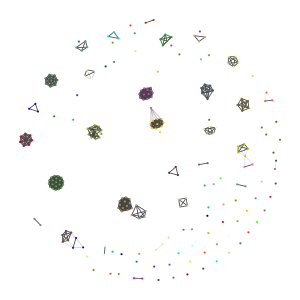

In [16]:
ddl.pl.igraph_network(results, colorby = 'clone_id')

There is a lot of information in the network construction and the gist is that a minimum spanning tree is constructed for each clone (or clone group) and cells that are part of a functional clone will have additional edges linking it up to other clonally related cells. The thickness of the edges here is inversely correlated to the similarity distance i.e. the more similar the BCRs are between two cells, the thicker the edges.

Anyway, the plot can be further adjusted by providing the `visual_style` option with a dictionary. The plotting function through `igraph` is extremely limited so we will make use of `scanpy`'s plotting modules later.

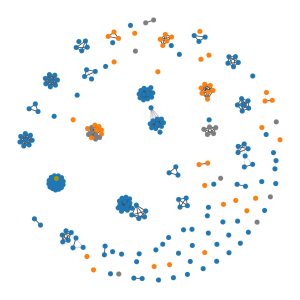

In [17]:
ddl.pl.igraph_network(results, colorby = 'status', visual_style = {'vertex_size':'5'})

This plotting function contains a few default color options for each of the columns in the metadata. Again, they can be adjusted as long as a dictionary containing color mappings is provided to the `visual_style` option.

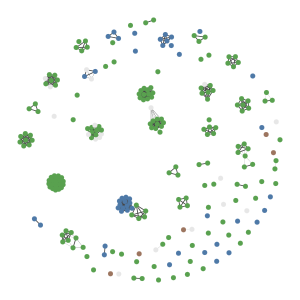

In [18]:
ddl.pl.igraph_network(results, colorby = 'isotype', visual_style = {'vertex_size':'5'})

Unfortunately this sample isn't a great example for showing whether clones are made up of non-productive and productive contigs because all of them are productive. But nevertheless, maybe with a different sample, we might have a better chance there.

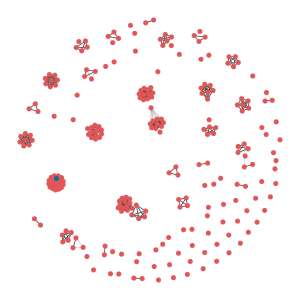

In [19]:
ddl.pl.igraph_network(results, colorby = 'productive', visual_style = {'vertex_size':'5'})

In both `tl.generate_networks` and `pl.igraph_network`, you can change the `layout` option. For example:

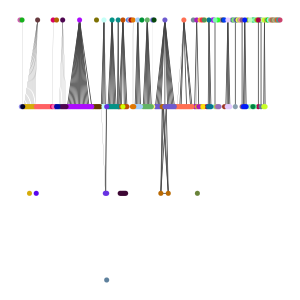

In [20]:
ddl.pl.igraph_network(results, colorby = 'clone_id', layout = 'sugiyama', visual_style = {'vertex_size':'5'})

The graph/network can be accessed through the `.graph` slot as an `igraph.graph` object in the `Dandelion` class object if you want to extract the data for network statistics or make any changes to the network.

### *utl.initialize_metadata*
Lastly, before continuing, the `.metadata` slot in Dandelion class automatically initializes whenever the `.data` slot is filled. It does so via the `utl.initialize_metadata` function. However, it only returns a standard number of columns that are pre-specified. To retrieve other columns in the `.data` slot, the option `retrieve` can be specified. you can also pass `collapse = False` if the two columns can be reasonably combined for that cell/barcode.

In [21]:
# for example:
ddl.utl.initialize_metadata(results)
results

Dandelion class object with n_obs = 243 and n_contigs = 468
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support', 'v_id

In [22]:
ddl.utl.initialize_metadata(results, retrieve = 'junction_aa')
results

Dandelion class object with n_obs = 243 and n_contigs = 468
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support', 'v_id

Note the additional columns in the metadata slot.

## Visualizing BCR network - Part 2
The results can also be ported into the `AnnData` object for access to more plotting functions provided through `scanpy`.

In [23]:
import warnings
warnings.filterwarnings('ignore')
sc.logging.print_versions()
adata = sc.read_h5ad(bcr_folder+sample+'/dandelion/data/adata.h5ad')
adata

scanpy==1.4.6 anndata==0.7.1 umap==0.4.3 numpy==1.17.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2


AnnData object with n_obs × n_vars = 820 × 3242 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'has_bcr_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Initialization of scanpy object

#### *tl.transfer_network*

To proceed, we first need to initialise the `AnnData` object with our network. This is done by using the tool function `tl.transfer_network`.

In [24]:
ddl.tl.transfer_network(adata, results)

Transferring network
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix
stored original .uns in .raw (0:00:02)


You can see that `AnnData` object now contains a couple more columns in the `.obs` slot, corresponding to the metadata that is returned after `tl.generate_network`, and a newly created `X_bcr` key in the `.obsm` slot. The original `.uns` slot was also stored in `.raw` in case you want to retrieve it.

In [25]:
adata

AnnData object with n_obs × n_vars = 820 × 3242 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'leiden', 'sample_id', 'clone_id', 'clone_group_id', 'isotype', 'lightchain', 'status', 'vdj_status', 'productive', 'umi_counts_heavy', 'umi_counts_light', 'v_call_heavy', 'v_call_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'junction_aa'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'has_bcr_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_bcr'
    varm: 'PCs'

## Plotting in scanpy

### *pl.plot_network*
So now, basically we can plot in `scanpy` with their plotting modules. I've included a plotting function in ***dandelion***, `pl.plot_network`, which is really just a wrapper of their `pl.embedding` module.

... storing 'sample_id' as categorical
... storing 'clone_id' as categorical
... storing 'clone_group_id' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'status' as categorical
... storing 'vdj_status' as categorical
... storing 'productive' as categorical
... storing 'umi_counts_heavy' as categorical
... storing 'umi_counts_light' as categorical
... storing 'v_call_heavy' as categorical
... storing 'v_call_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical
... storing 'junction_aa' as categorical
posx and posy should be finite values
posx and posy should be finite values


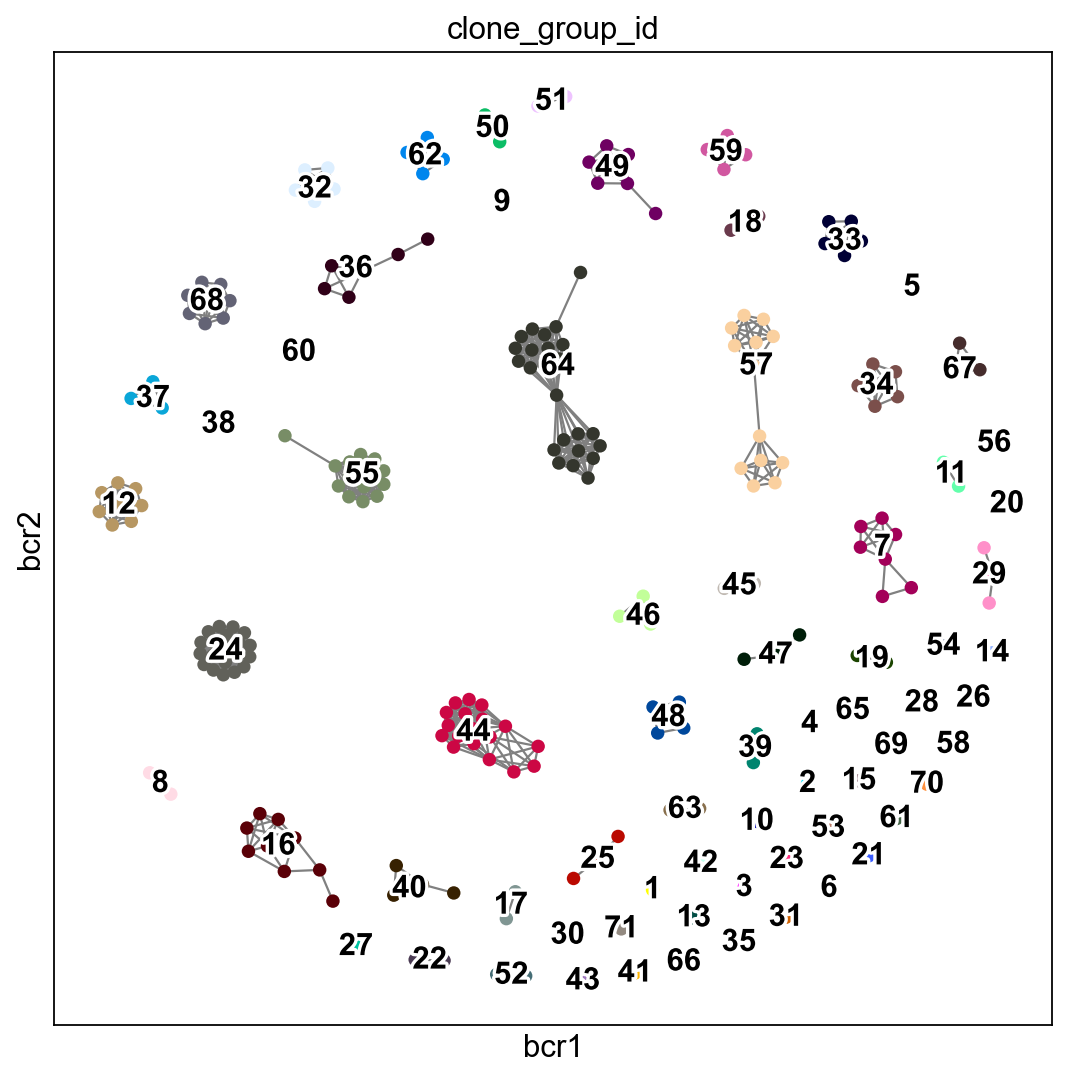

In [26]:
sc.set_figure_params(figsize = [8,8])
ddl.pl.plot_network(adata, color = ['clone_group_id'], legend_loc = 'on data', legend_fontoutline=3, edges_width = 1)

You can interact with `pl.plot_network` just as how you interact with the rest of the scatterplot modules in `scanpy`.

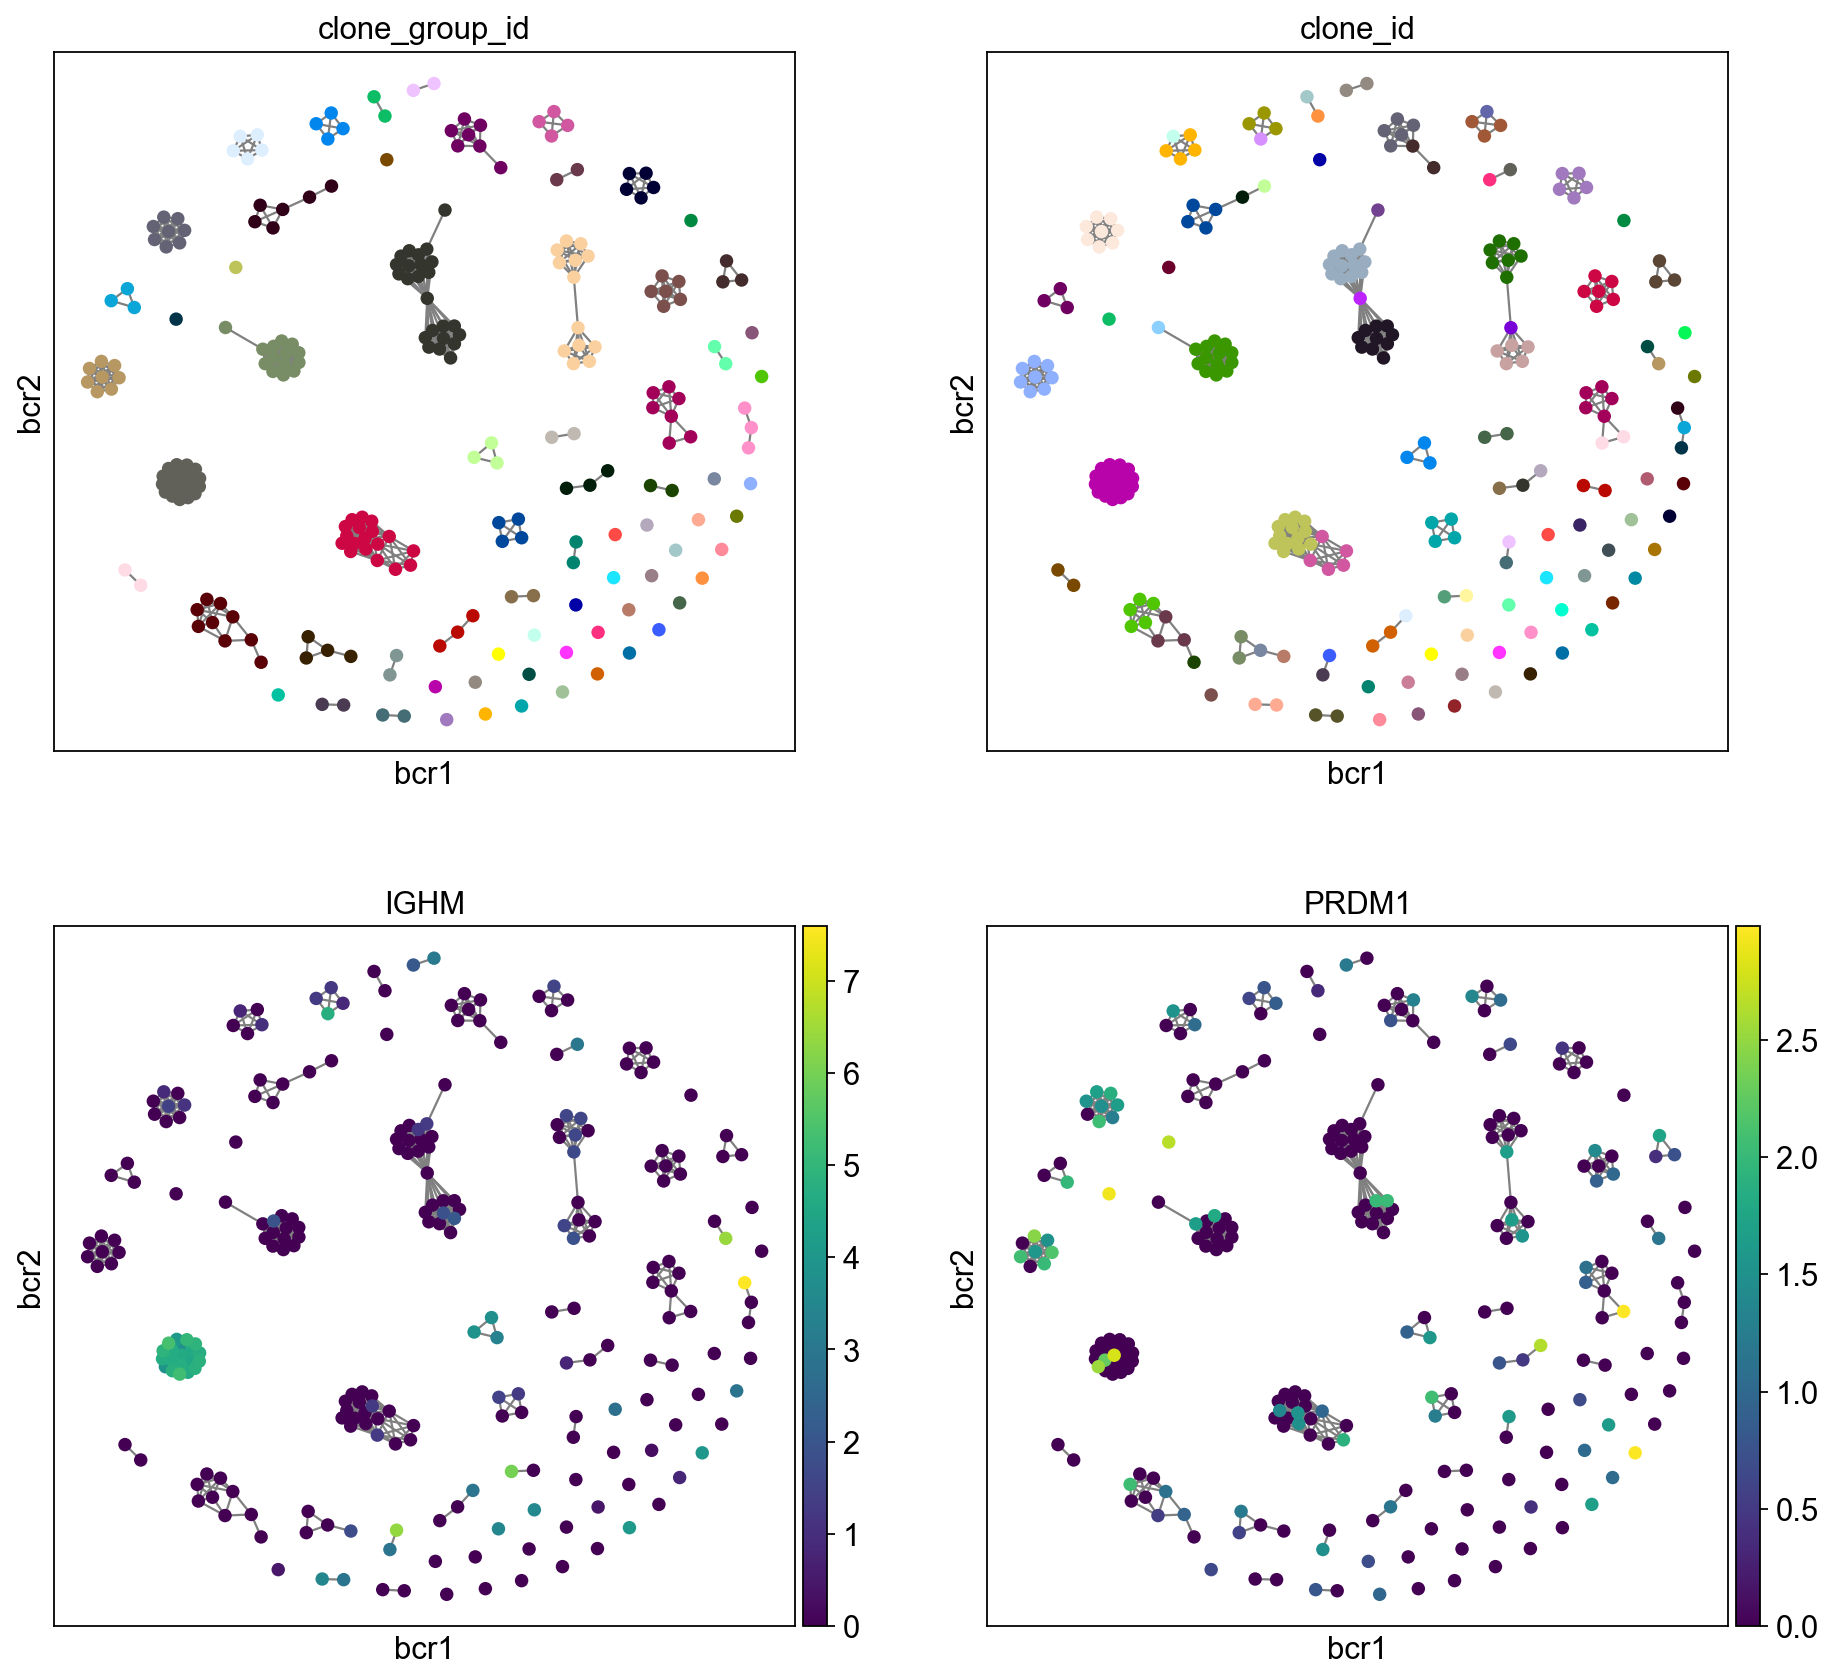

In [27]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.plot_network(adata, color = ['clone_group_id', 'clone_id', 'IGHM', 'PRDM1'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1)

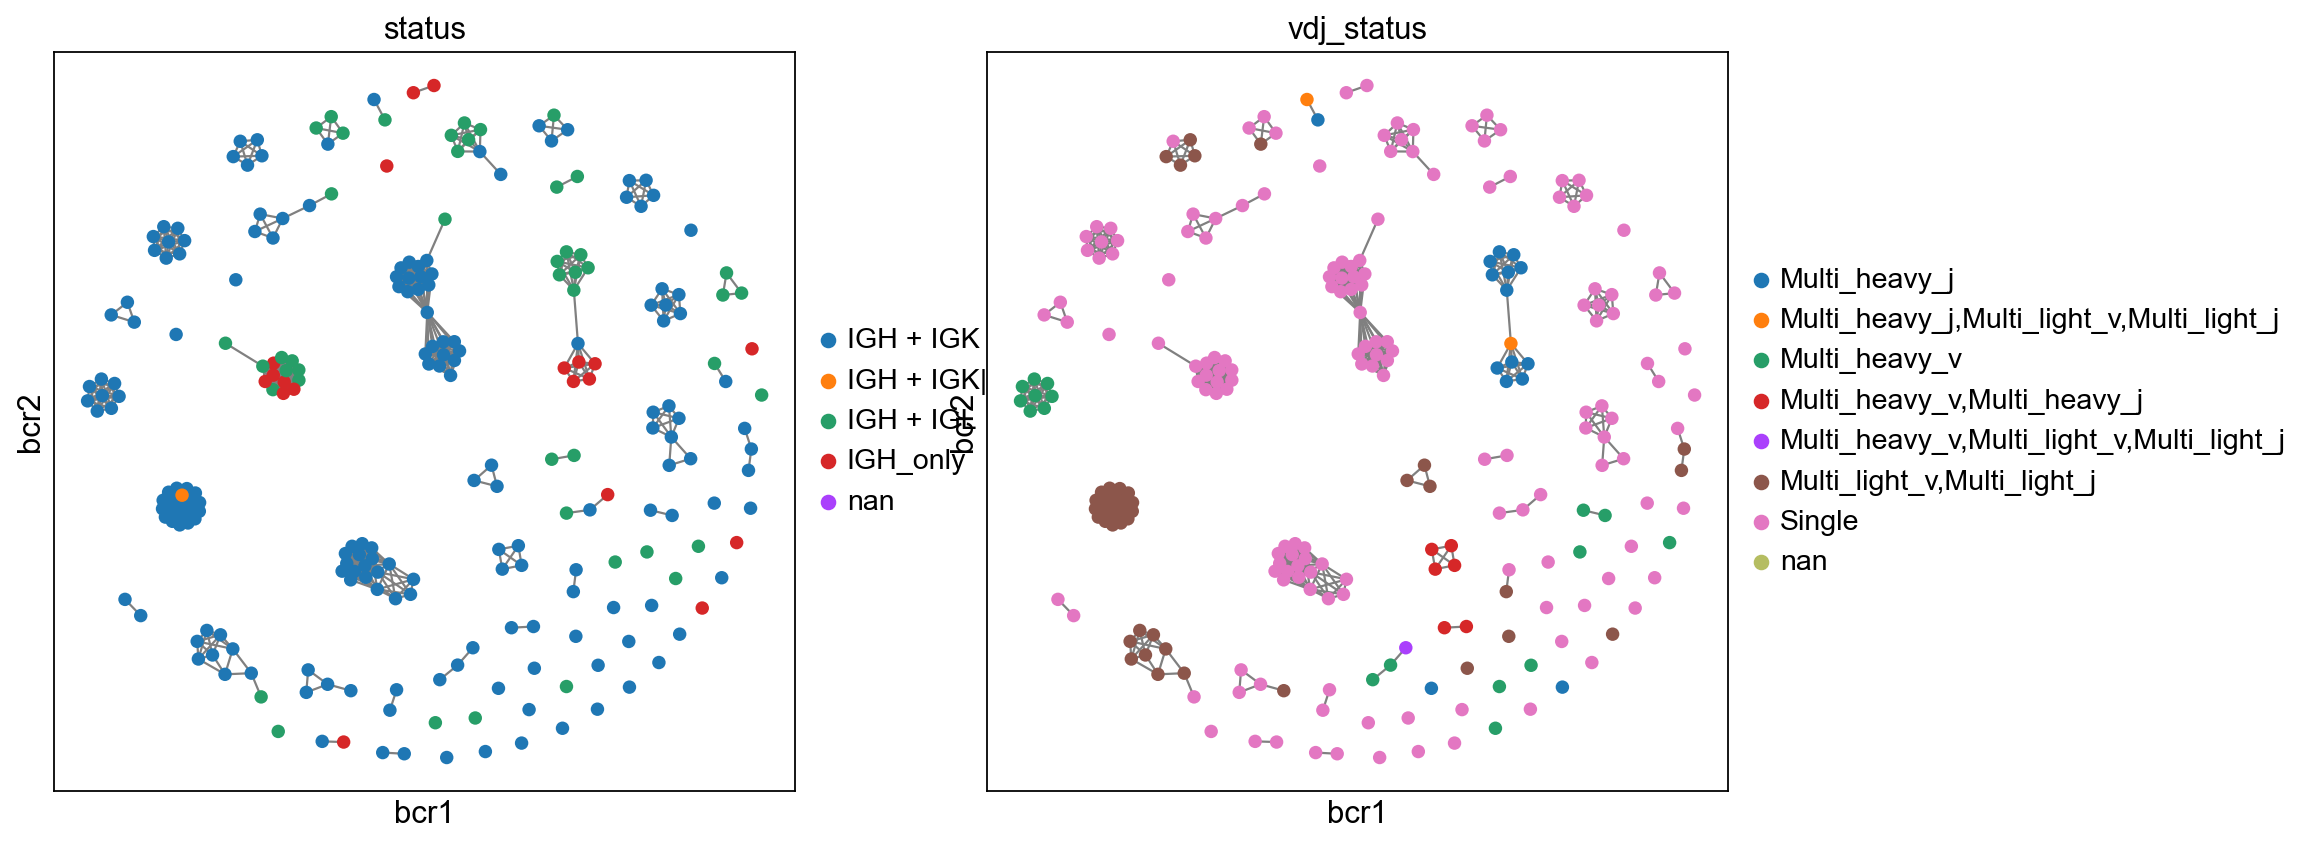

In [28]:
ddl.pl.plot_network(adata, color = ['status', 'vdj_status'], ncols = 2, legend_fontoutline=3, edges_width = 1)

Compared to plots in umap, I think this visualisation is a bit more useful for looking at BCR clones.

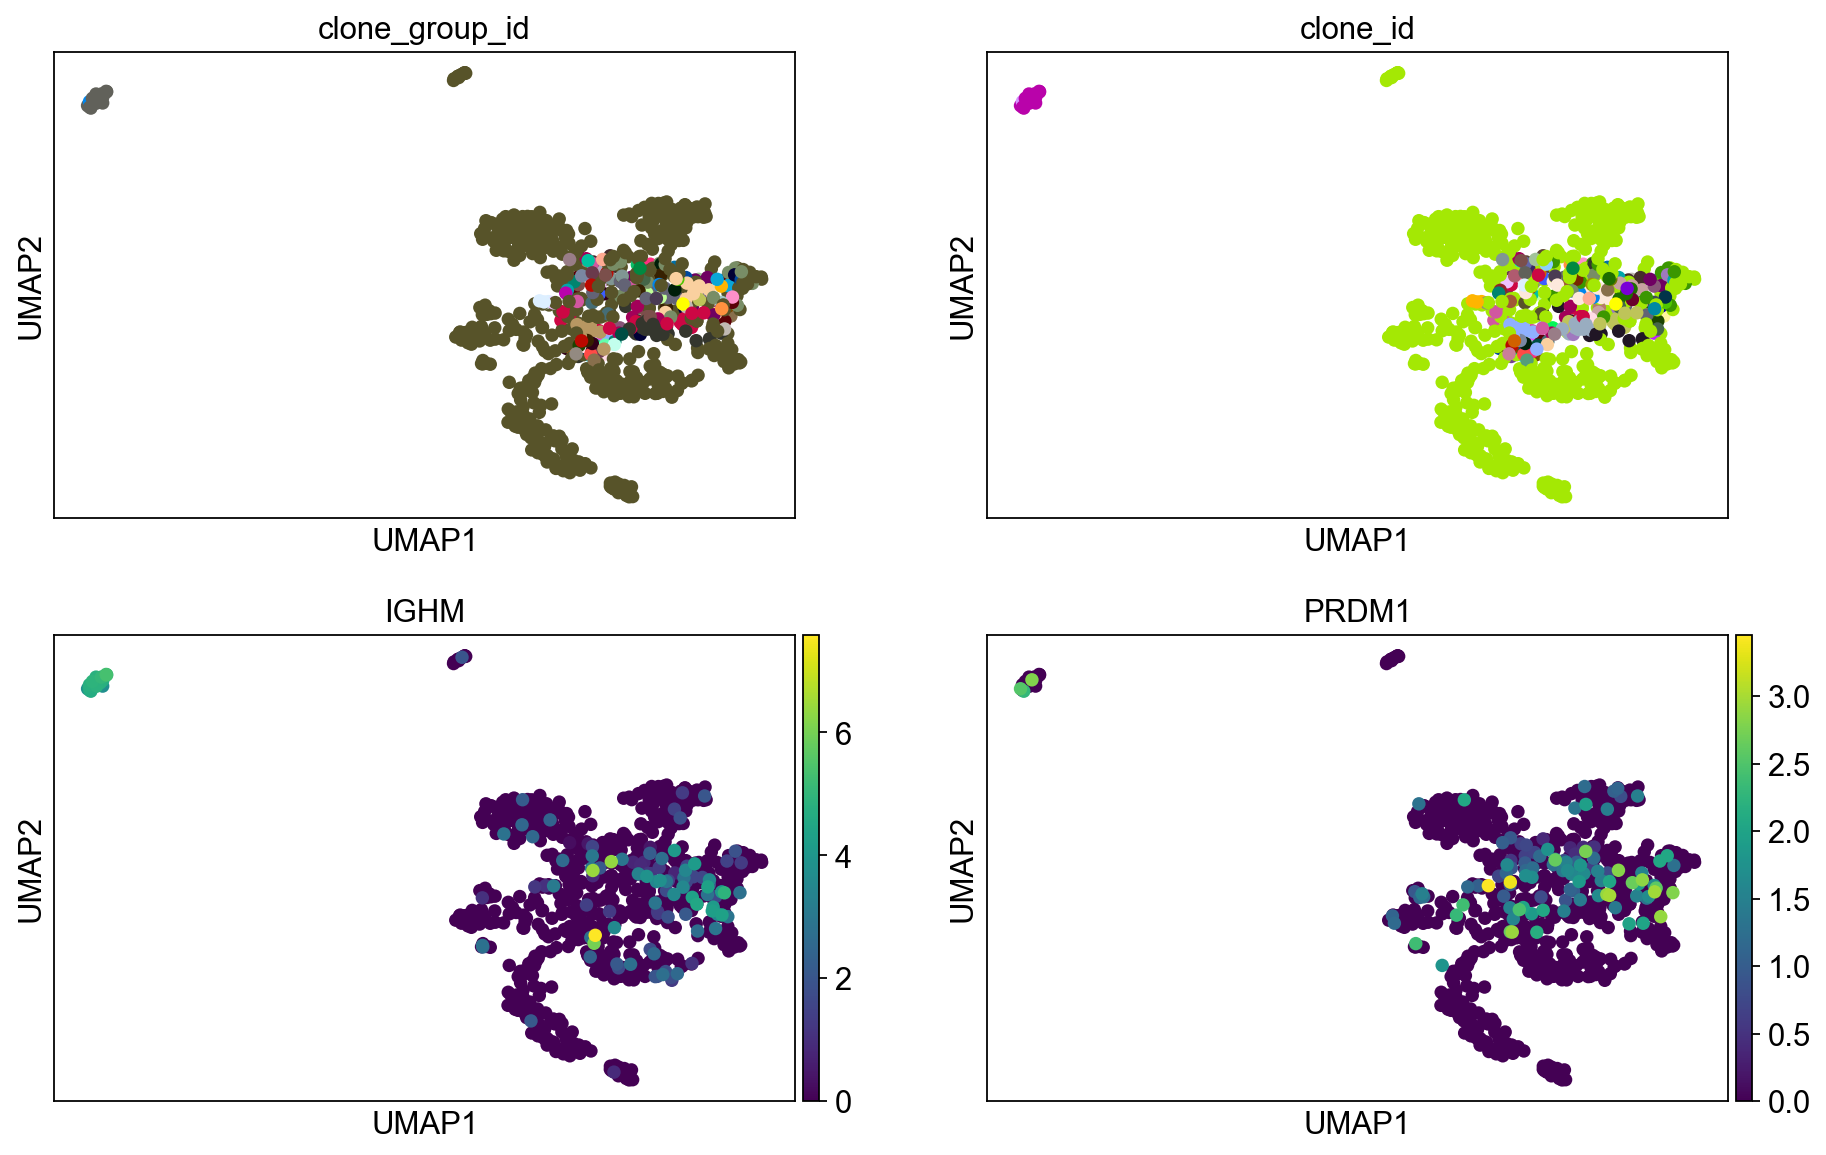

In [29]:
sc.set_figure_params(figsize = [6,4])
sc.pl.umap(adata, color = ['clone_group_id', 'clone_id', 'IGHM', 'PRDM1'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1)

### Calculating mutational load
To calculate mutational load, I've ported the functions from immcantation suite's changeo and shazam to work with the `dandelion` class object.

We first need to mask the D genes from the germline sequences with the tools function `pp.create_germlines`. **Note, this has been taken care of if you've already run `pp.reassign_alleles`.** You can store the germline reference updated with the personalized germline reference from `pp.reassign_alleles` within `Dandelion` object by running the following.

In [30]:
# if GERMLINE environmental variable is not set or swapping/using a different germline reference, please specify the `germline` option with the path to the database or the germline reference as a dictionary.
results.update_germline(corrected = bcr_folder+'A31/dandelion/data/all_contig_heavy_igblast_gap_genotype.fasta', germline = None, org = 'human')

Updating germline reference
 finished: Updated Dandelion object: 
   'germline', updated germline reference
 (0:00:00)


### *pp.create_germlines*

Then we run `pp.create_germline` to create the `germline_alignment_d_mask` column in the data. If `update_germline` was run like above, there's no need to specify the `germline` option as the function will simply retrieve it from the `Dandelion` object. As mentioned, **this has been taken care of if you've already run `pp.reassign_alleles`** and there's no need to run it.

In [31]:
ddl.pp.create_germlines(results)

Reconstructing germline sequences


   Building dmask germline sequences: 468it [00:01, 460.80it/s]


 finished: Updated Dandelion object: 
   'data', updated germline alignment in contig-indexed clone table
   'germline', updated germline reference
 (0:00:02)


The default behaviour is to mask the D with Ns `germ_types = 'dmask'`. See [here](https://changeo.readthedocs.io/en/stable/methods/germlines.html) for more info. Here, I'm updating the original germline_alignment column with the corrected alignment:

In [32]:
ddl.pp.create_germlines(results, germ_types = 'full')

Reconstructing germline sequences


   Building full germline sequences: 468it [00:00, 475.16it/s]


 finished: Updated Dandelion object: 
   'data', updated germline alignment in contig-indexed clone table
   'germline', updated germline reference
 (0:00:02)


### *tl.quantify_mutations*
The options for quantify_mutations are the same as the basic mutational load analysis [vignette](https://shazam.readthedocs.io/en/version-0.1.8---mutation-profiling-enhancements/vignettes/Mutation-Vignette/). The default behavior is to sum all mutations scores (heavy and light chains, silent and replacement mutations) for the same cell.

In [33]:
ddl.tl.quantify_mutations(results)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:02)


If you want to split the calculation up between replacement (R) and silent (S) mutations, specify `combine = False`.

In [34]:
ddl.tl.quantify_mutations(results, combine = False)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:02)


Specifying `split_locus = True` will split up the results for the different chains.

In [35]:
ddl.tl.quantify_mutations(results, split_locus = True)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:02)


To update the `AnnData` object, simply rerun `tl.transfer_network` with keep_raw option set to `False` to avoid overwriting the stashed neighborhood graph.

In [36]:
ddl.tl.transfer_network(adata, results, keep_raw = False)

Transferring network
 finished: updated `.obs` with `.metadata`
 (0:00:00)


You can now visualise the mutation rate on via the plotting modules.

... storing 'sample_id' as categorical
... storing 'clone_id' as categorical
... storing 'clone_group_id' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'status' as categorical
... storing 'vdj_status' as categorical
... storing 'productive' as categorical
... storing 'umi_counts_heavy' as categorical
... storing 'umi_counts_light' as categorical
... storing 'v_call_heavy' as categorical
... storing 'v_call_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical


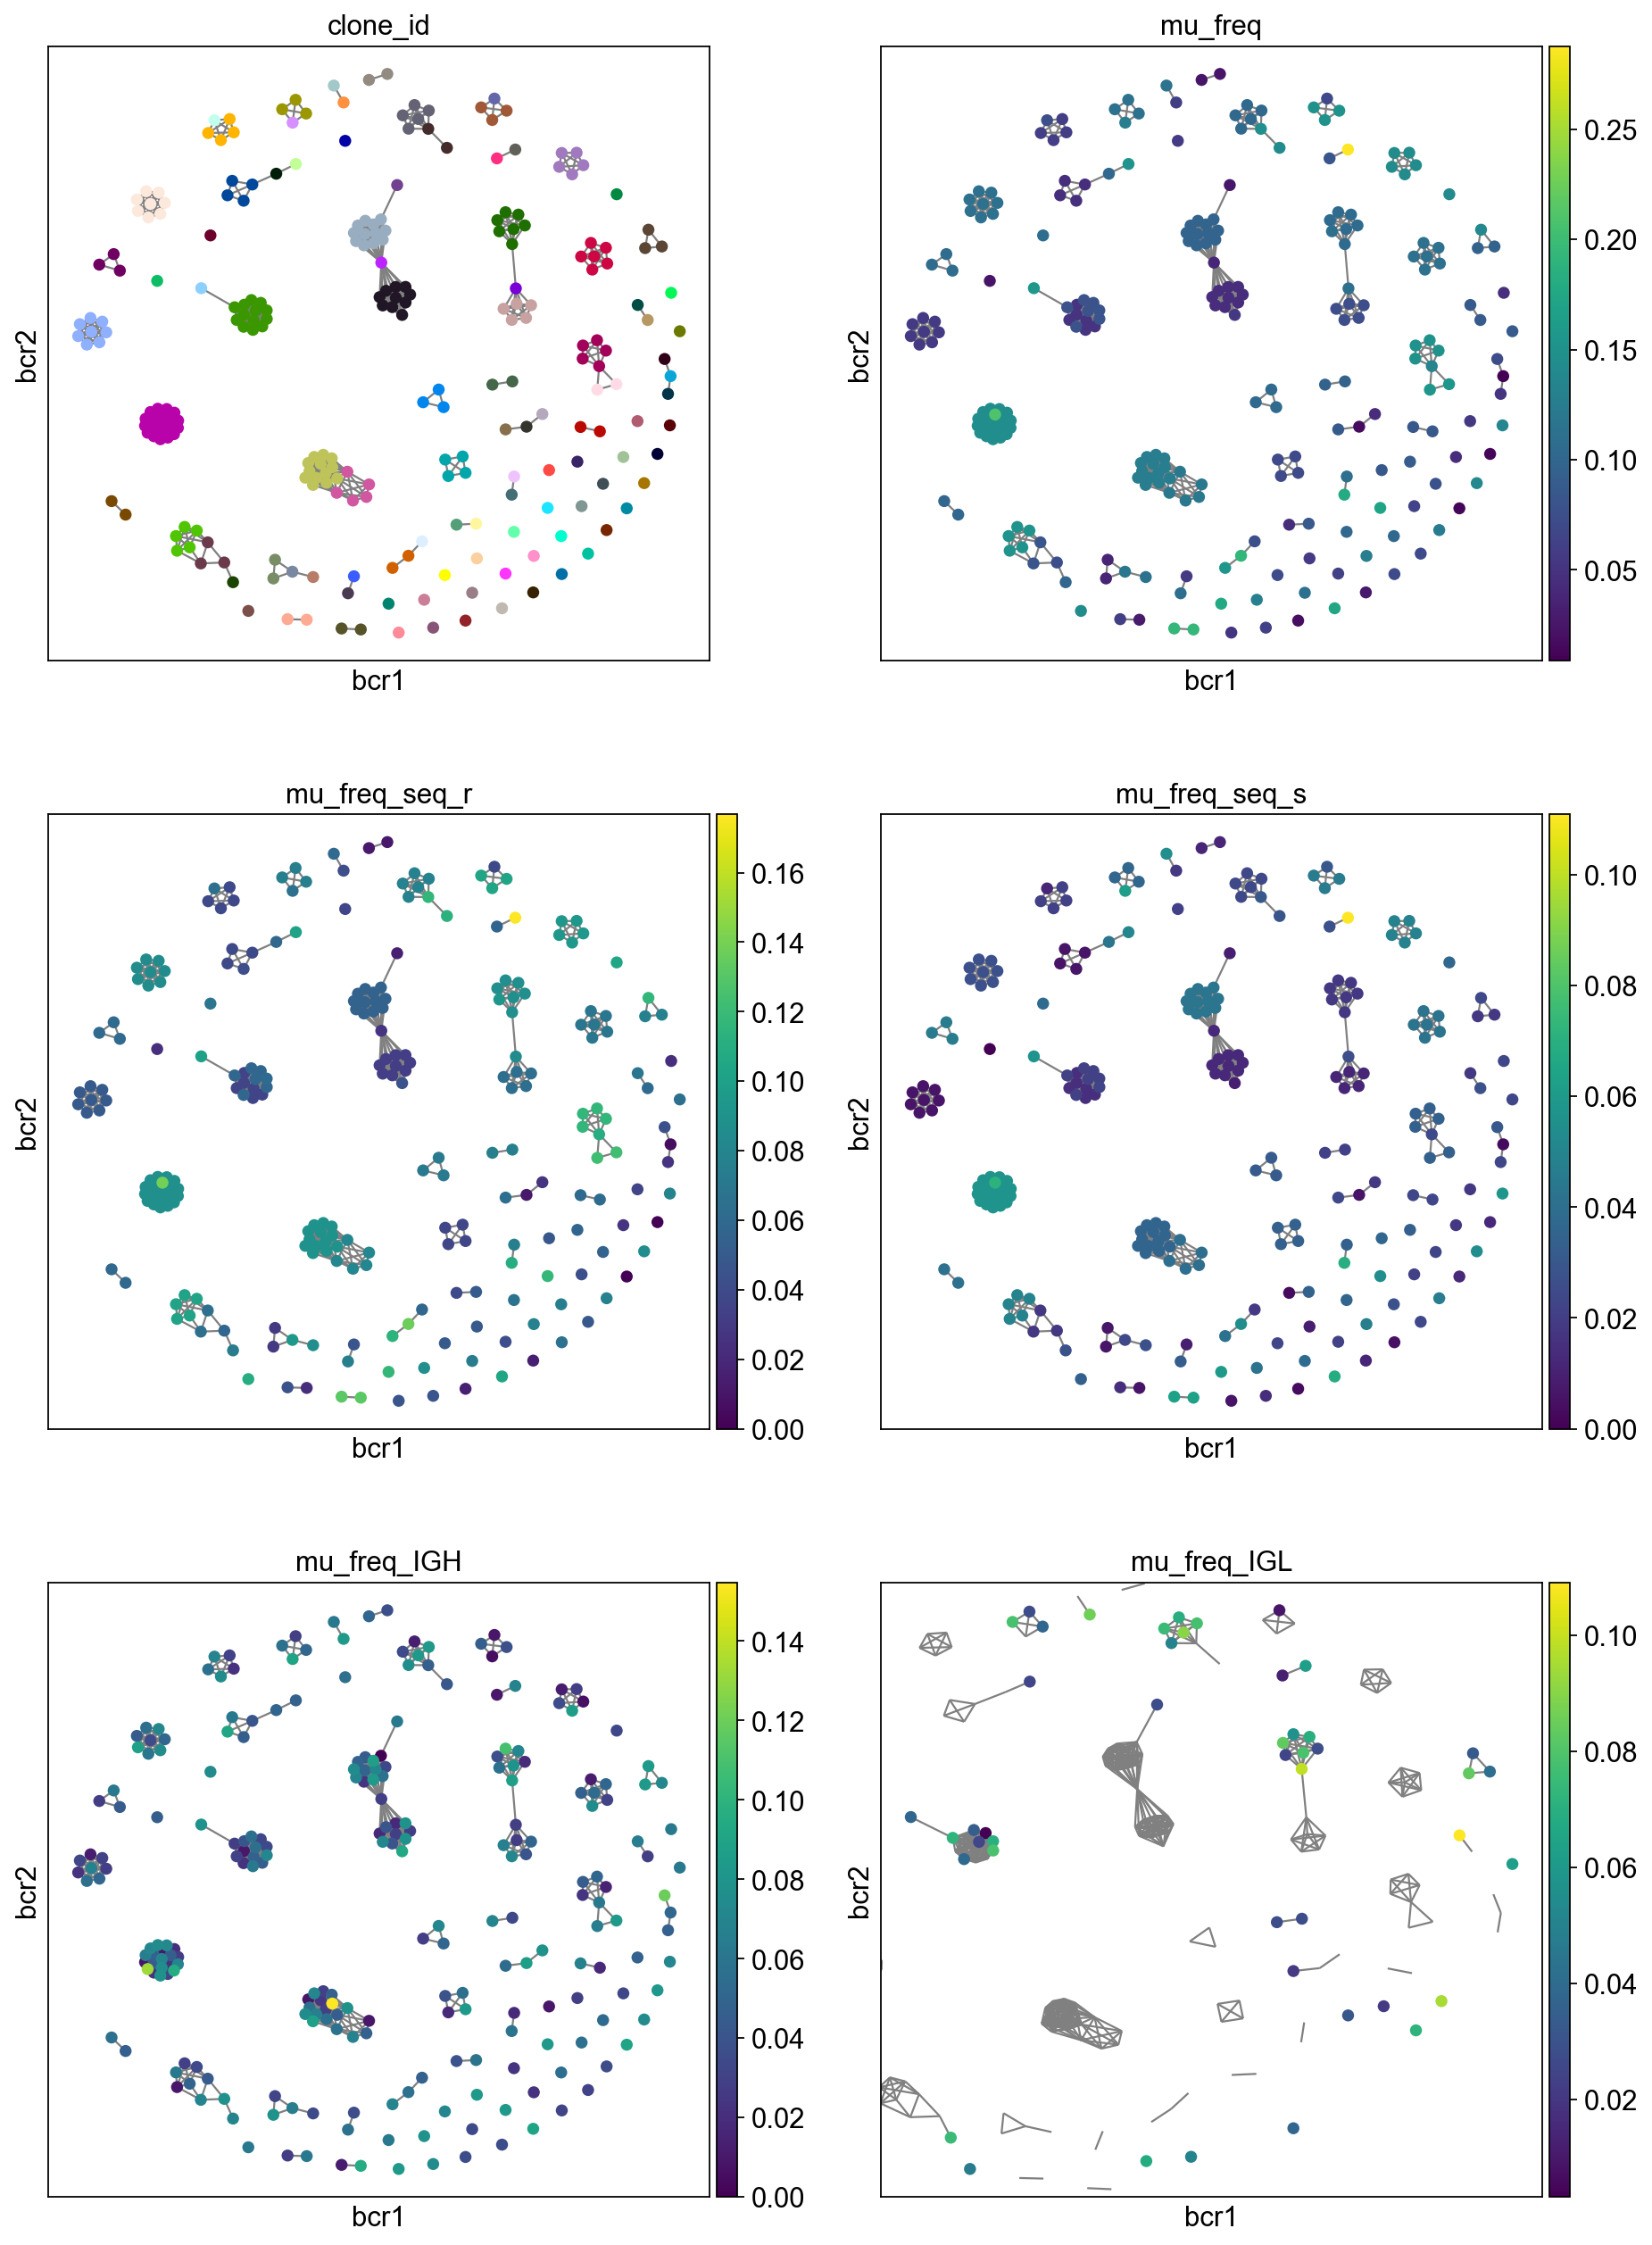

In [37]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.plot_network(adata, color = ['clone_id', 'mu_freq', 'mu_freq_seq_r', 'mu_freq_seq_s', 'mu_freq_IGH', 'mu_freq_IGL'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1)

#### Saving
At this stage, the data can be saved. For scanpy objects they can be saved as per usual using `.write` module. With the `Dandelion` class, we can save it with *pickle* module which can be triggered directly through `.save`:

In [38]:
results.save('Pan_immune_BCR/Pan_T7918901/dandelion/data/dandelion_results.pkl')

if you need to save the contig table as a .tsv file to interact with other packages, you can use `pandas.DataFrame.to_csv` on the `.data` slot of the `Dandelion` class object.

In [39]:
results.data.to_csv('Pan_immune_BCR/Pan_T7918901/dandelion/data/results.tsv', sep ='\t', index = False)

## Additional plotting functions

## *barplot*
`pl.barplot` is a generic barplot function that will plot items in the metadata slot as a bar plot. This function will also interact with `.obs` slot if a `scanpy` object is used in place of `Dandelion` object. However, if your `scanpy` object holds a lot of non-B cells, then the plotting will be just be saturated with nan values.

(<Figure size 1200x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x136e8c790>)

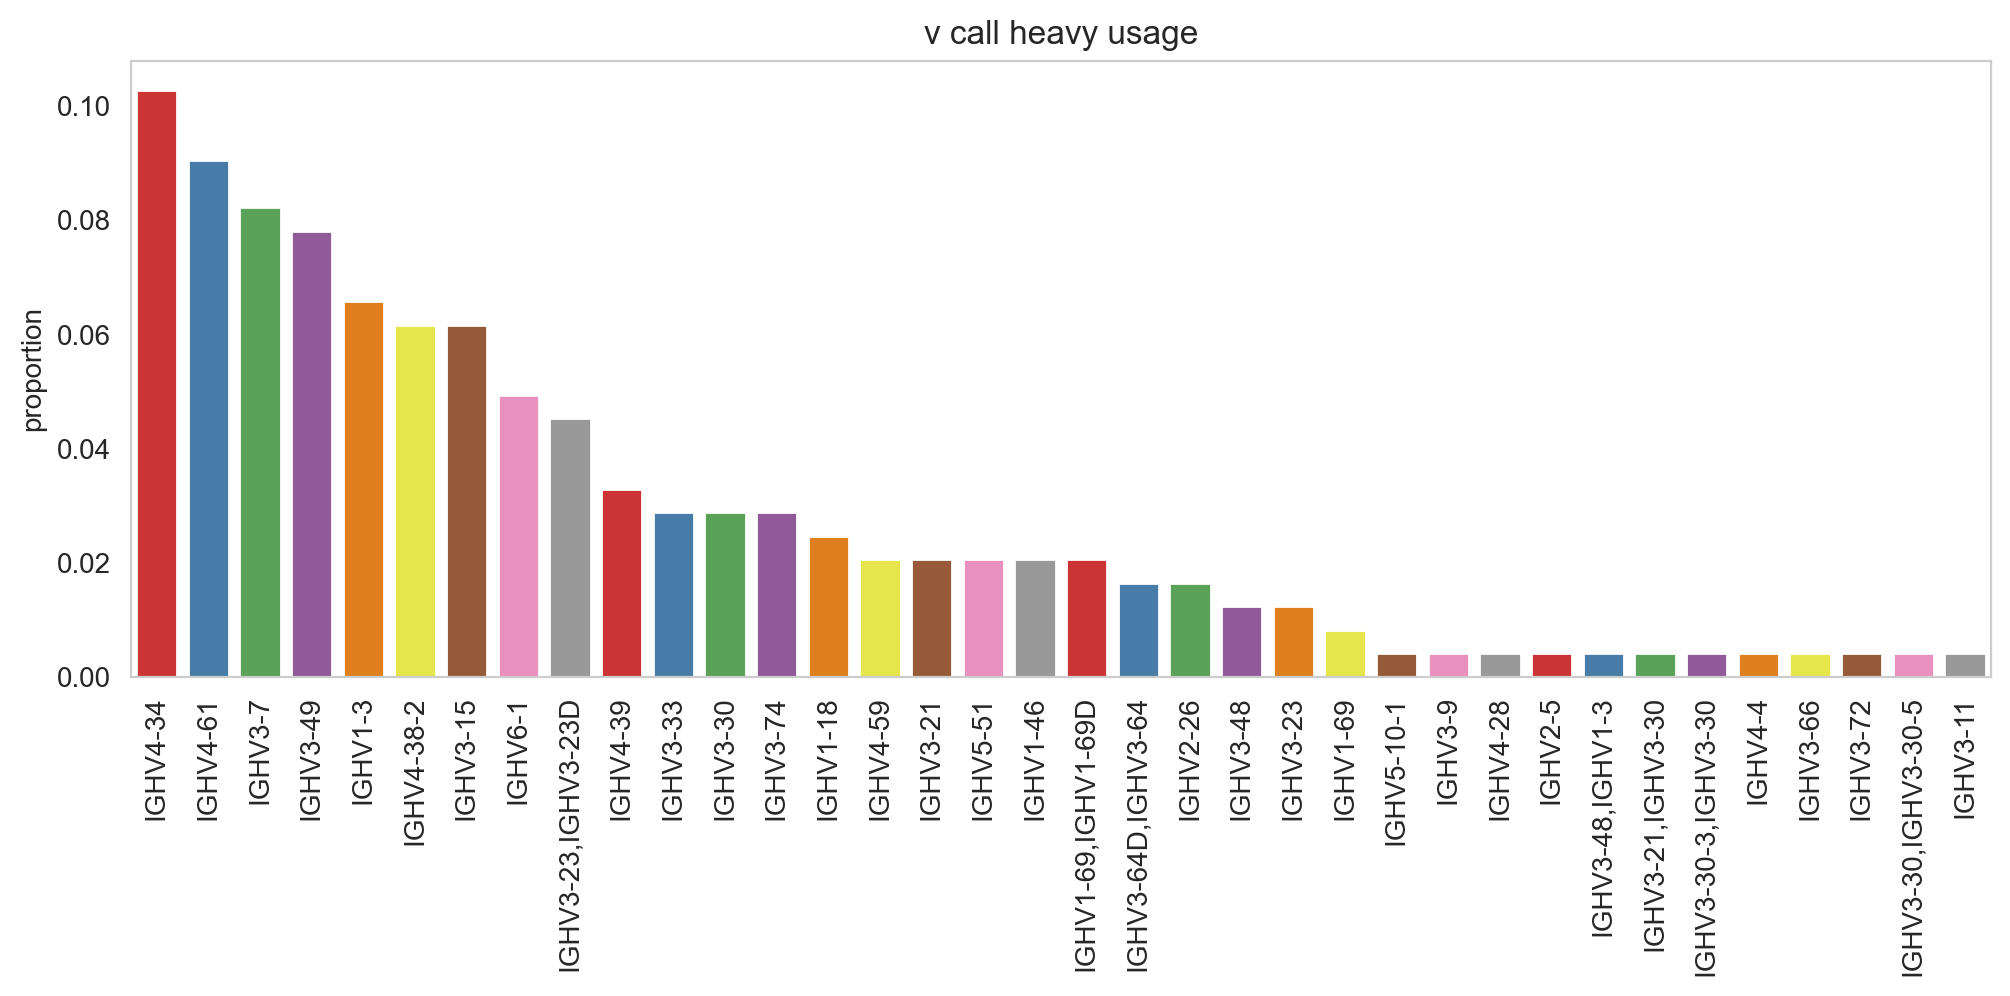

In [40]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
ddl.pl.barplot(results, variable = 'v_call_heavy', figsize = (12, 4))

You can prevent it from sorting by specifying `sort_descending = None`. Colours can be changed with `palette` option.

(<Figure size 1200x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137276f50>)

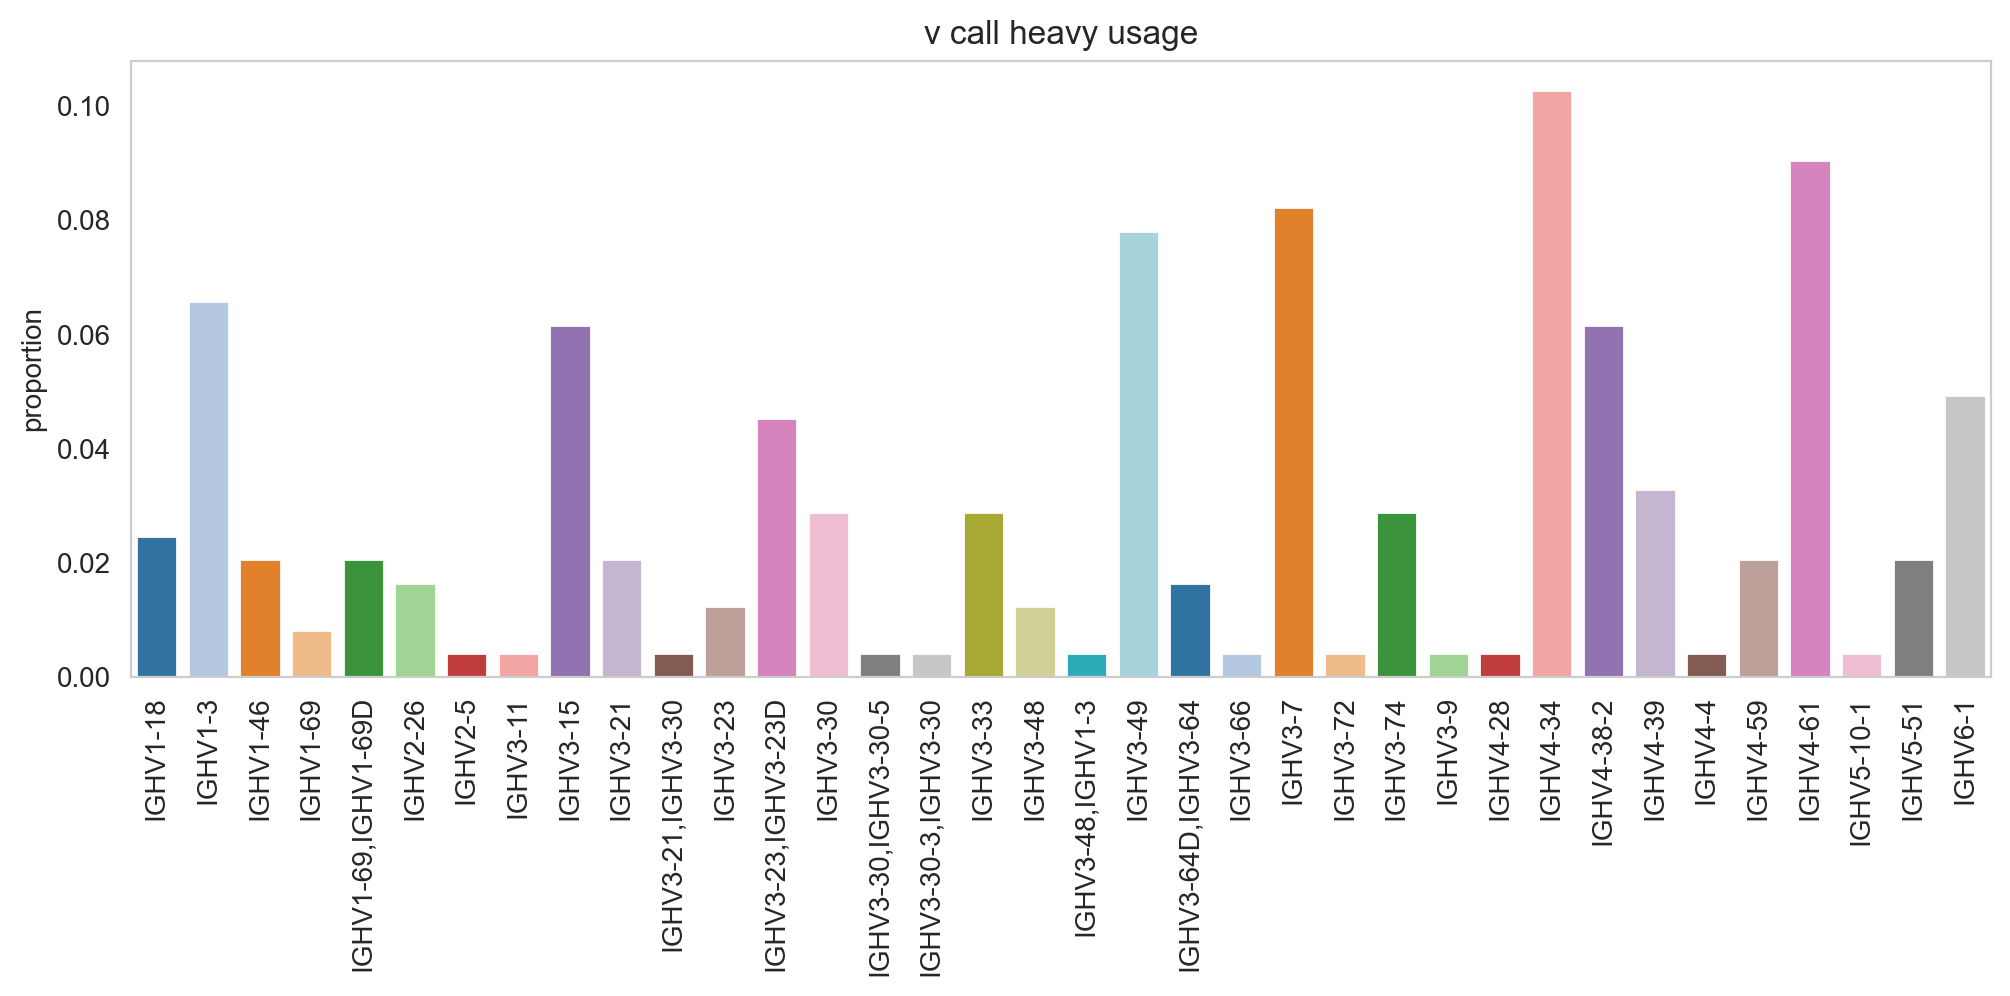

In [41]:
ddl.pl.barplot(results, variable = 'v_call_heavy', figsize = (12, 4), sort_descending = None, palette = 'tab20')

Specifying `normalize = False` will change the y-axis to counts.

(<Figure size 1200x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13523ca10>)

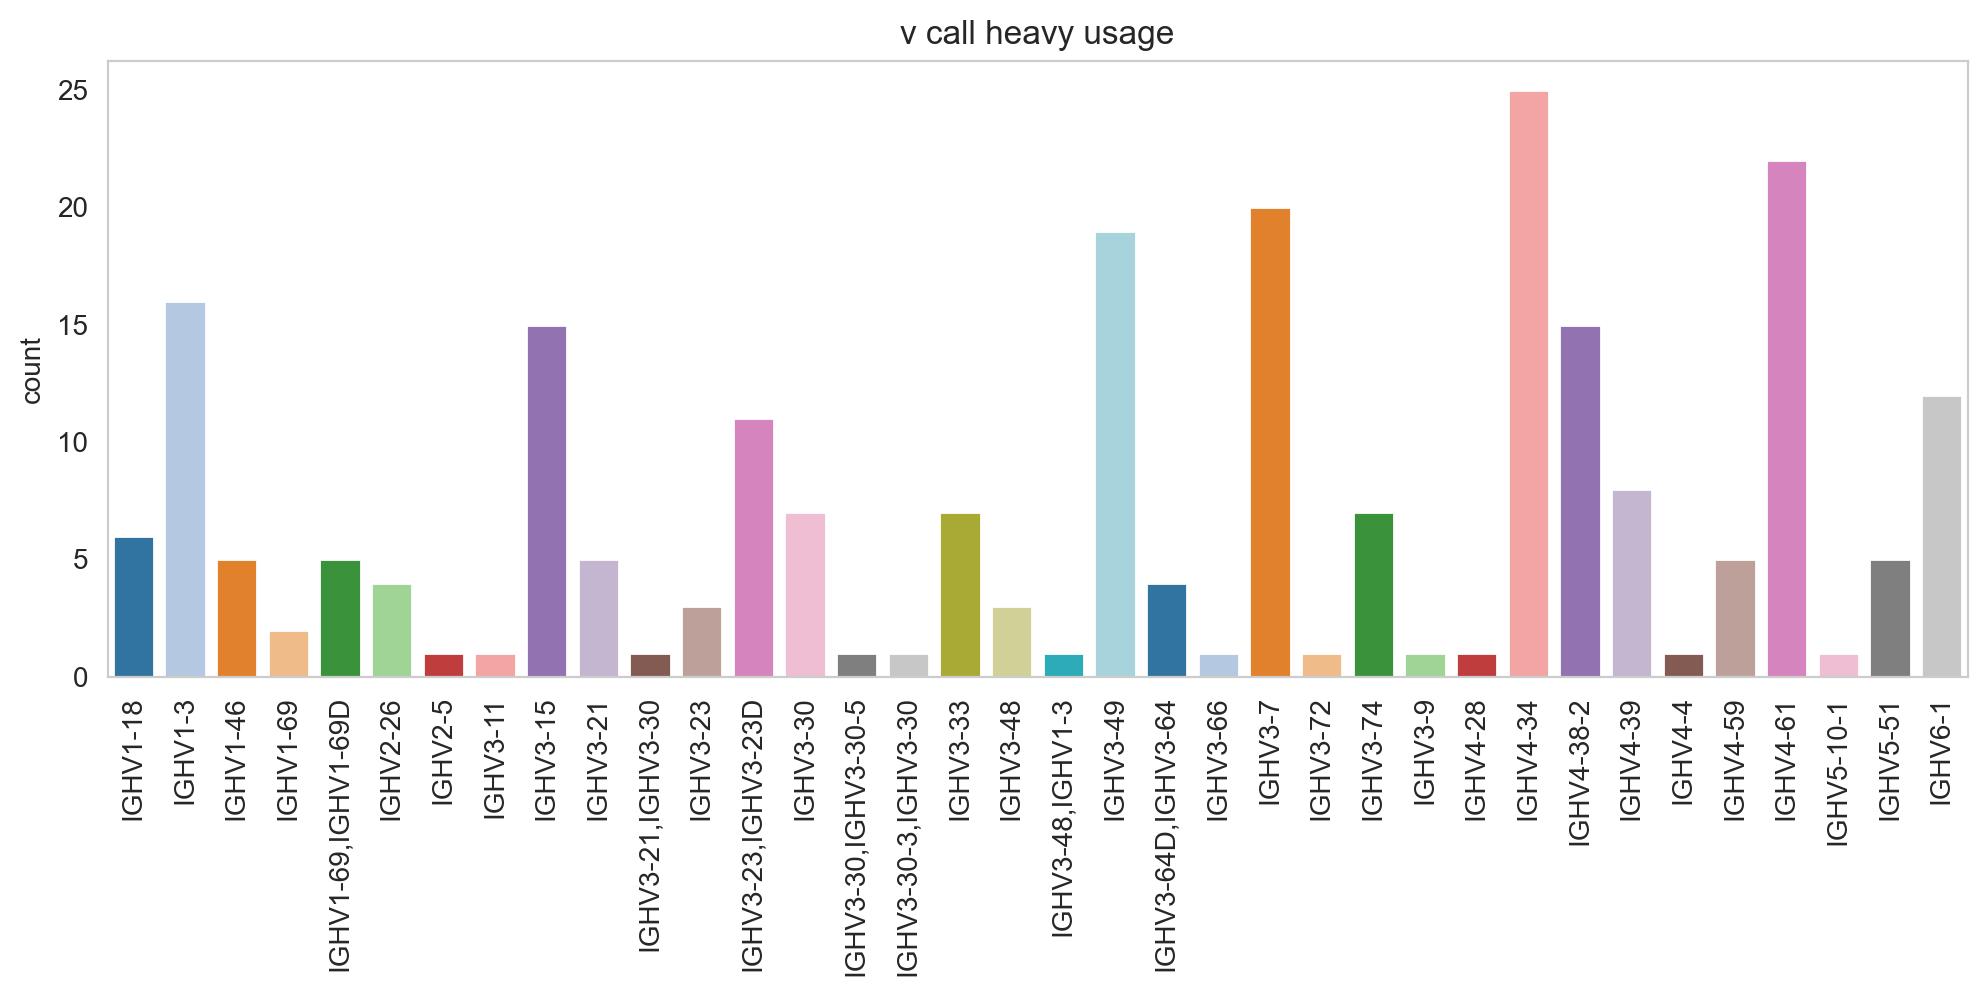

In [42]:
ddl.pl.barplot(results, variable = 'v_call_heavy', normalize = False, figsize = (12, 4), sort_descending = None, palette = 'tab20')

## *stackedbarplot*
`pl.stackedbarplot` is similar to above but can split between specified groups. Some examples below:

(<Figure size 400x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d635490>)

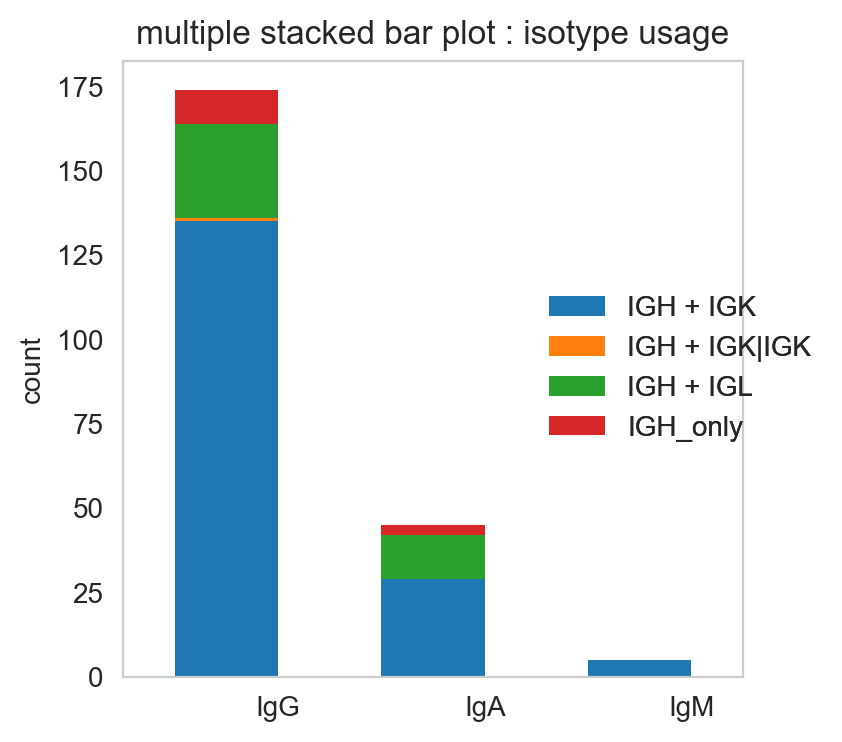

In [43]:
ddl.pl.stackedbarplot(results, variable = 'isotype', groupby = 'status', xtick_rotation =0, figsize = (4,4))

(<Figure size 1200x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x136f729d0>)

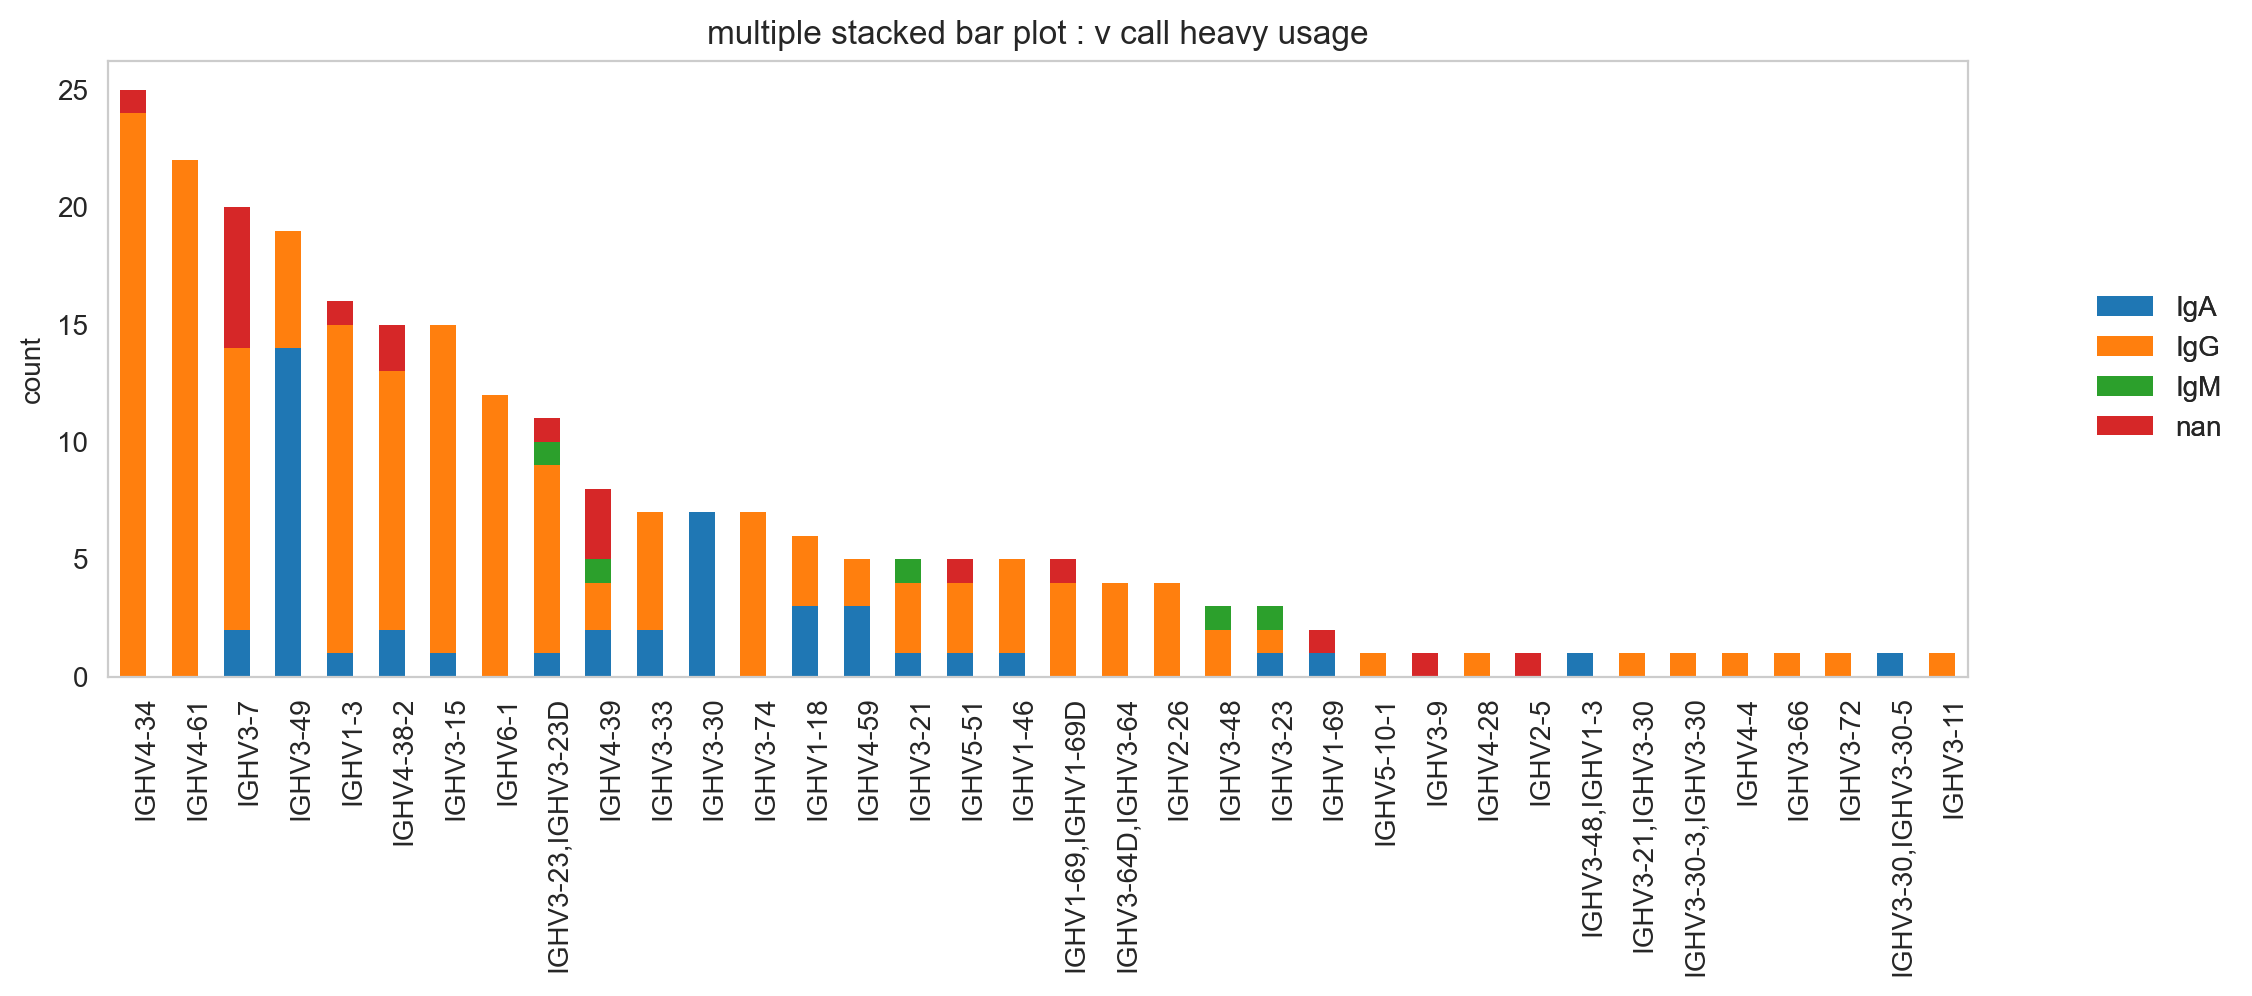

In [44]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'isotype')

(<Figure size 1200x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134218590>)

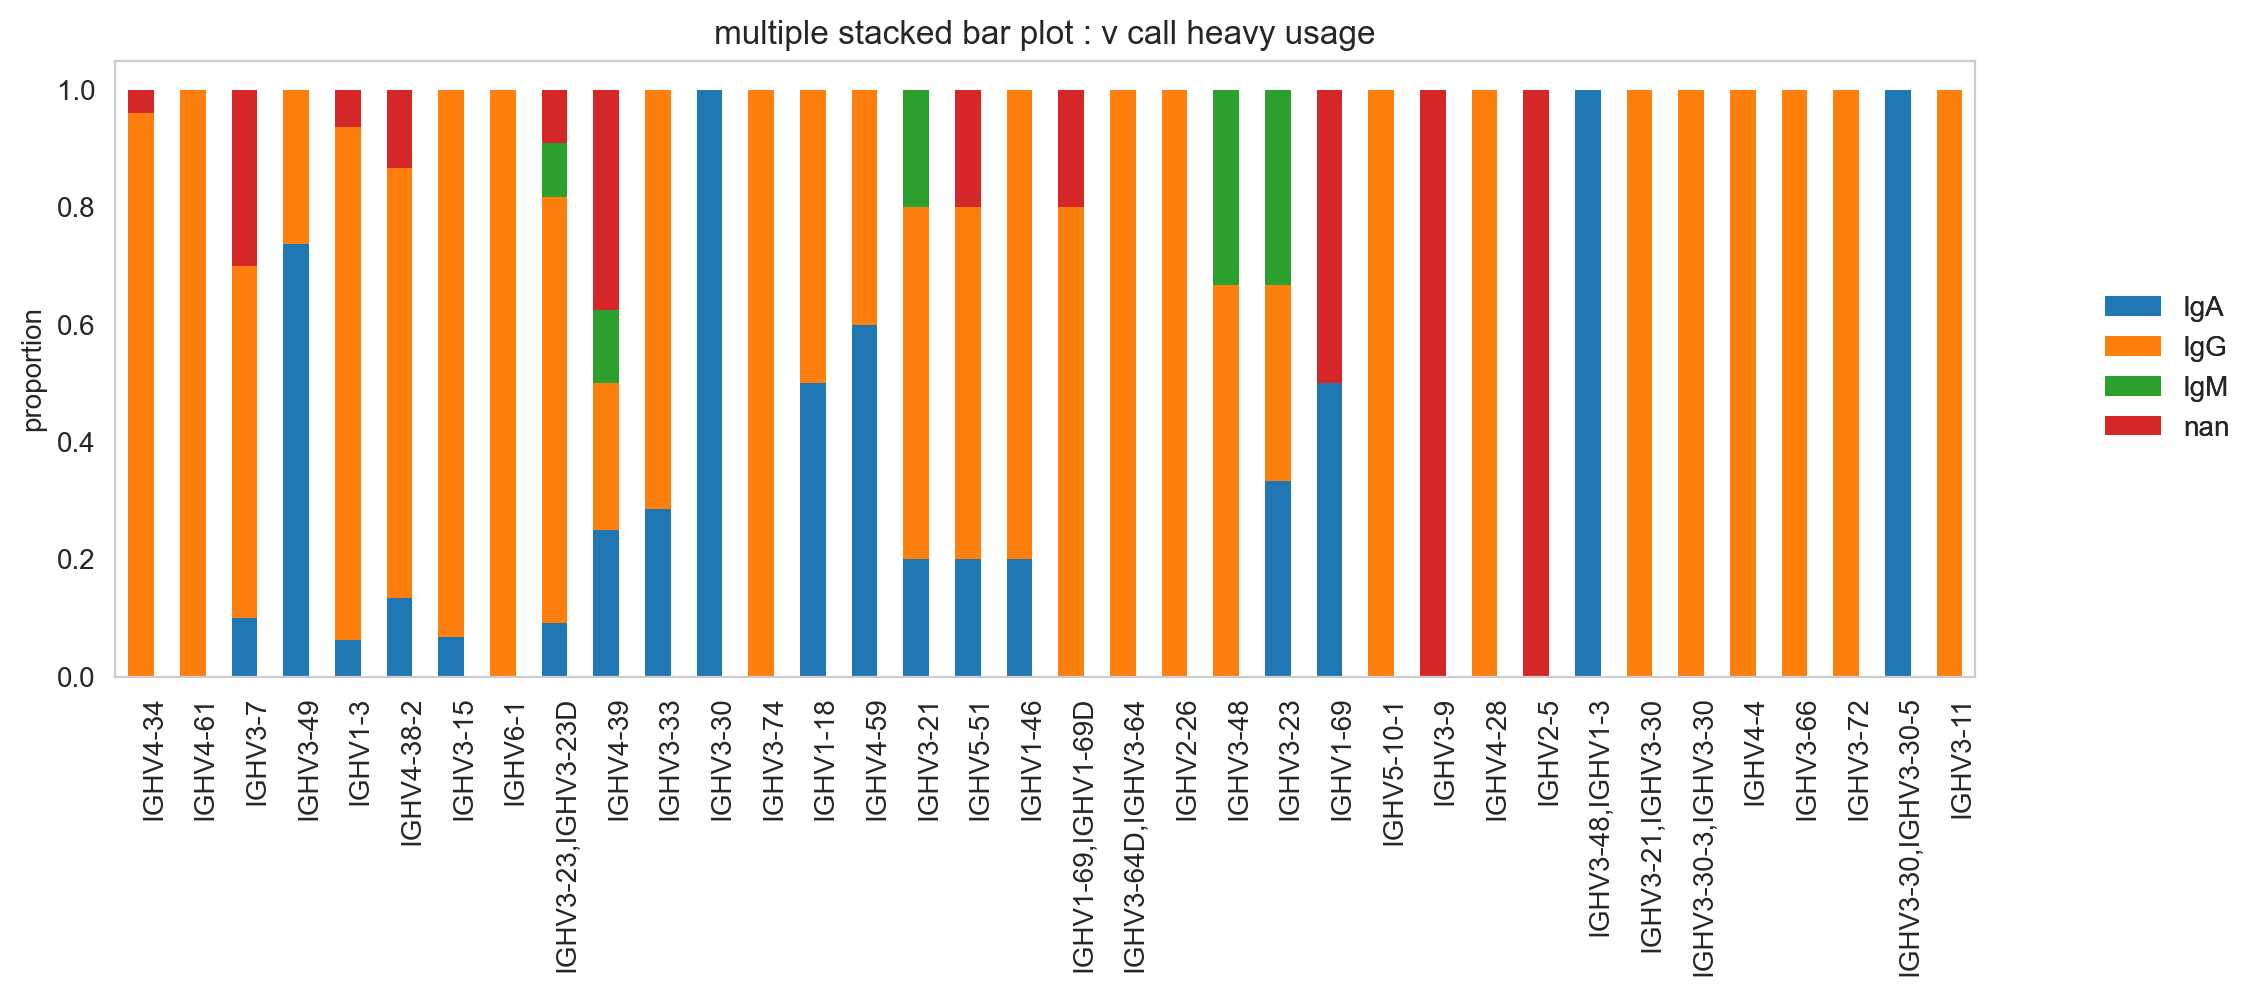

In [45]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'isotype', normalize = True)

(<Figure size 1200x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1341f8710>)

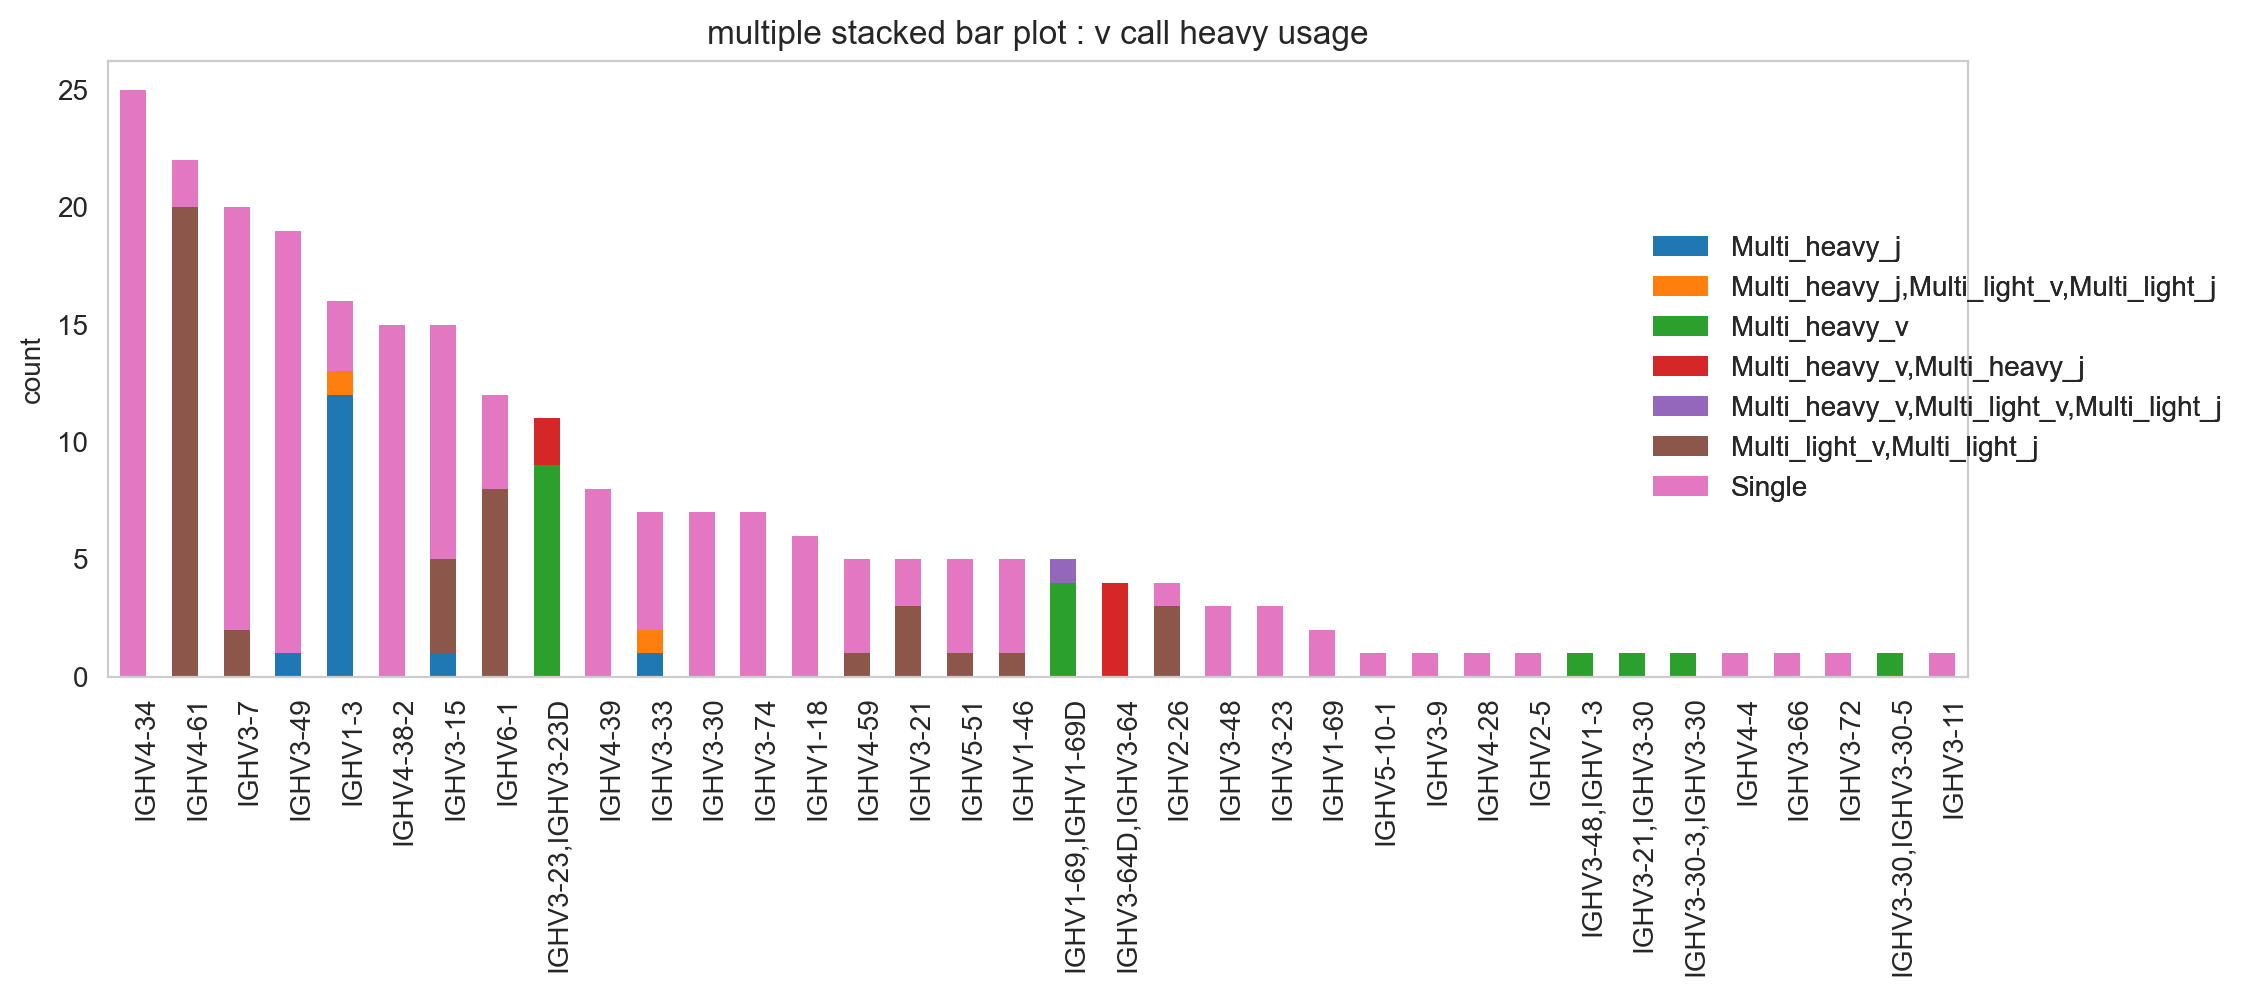

In [46]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'vdj_status')

It's obviously more useful if you don't have too many groups, but you could try and plot everything and jiggle the legend options and color.

(<Figure size 1200x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x136641610>)

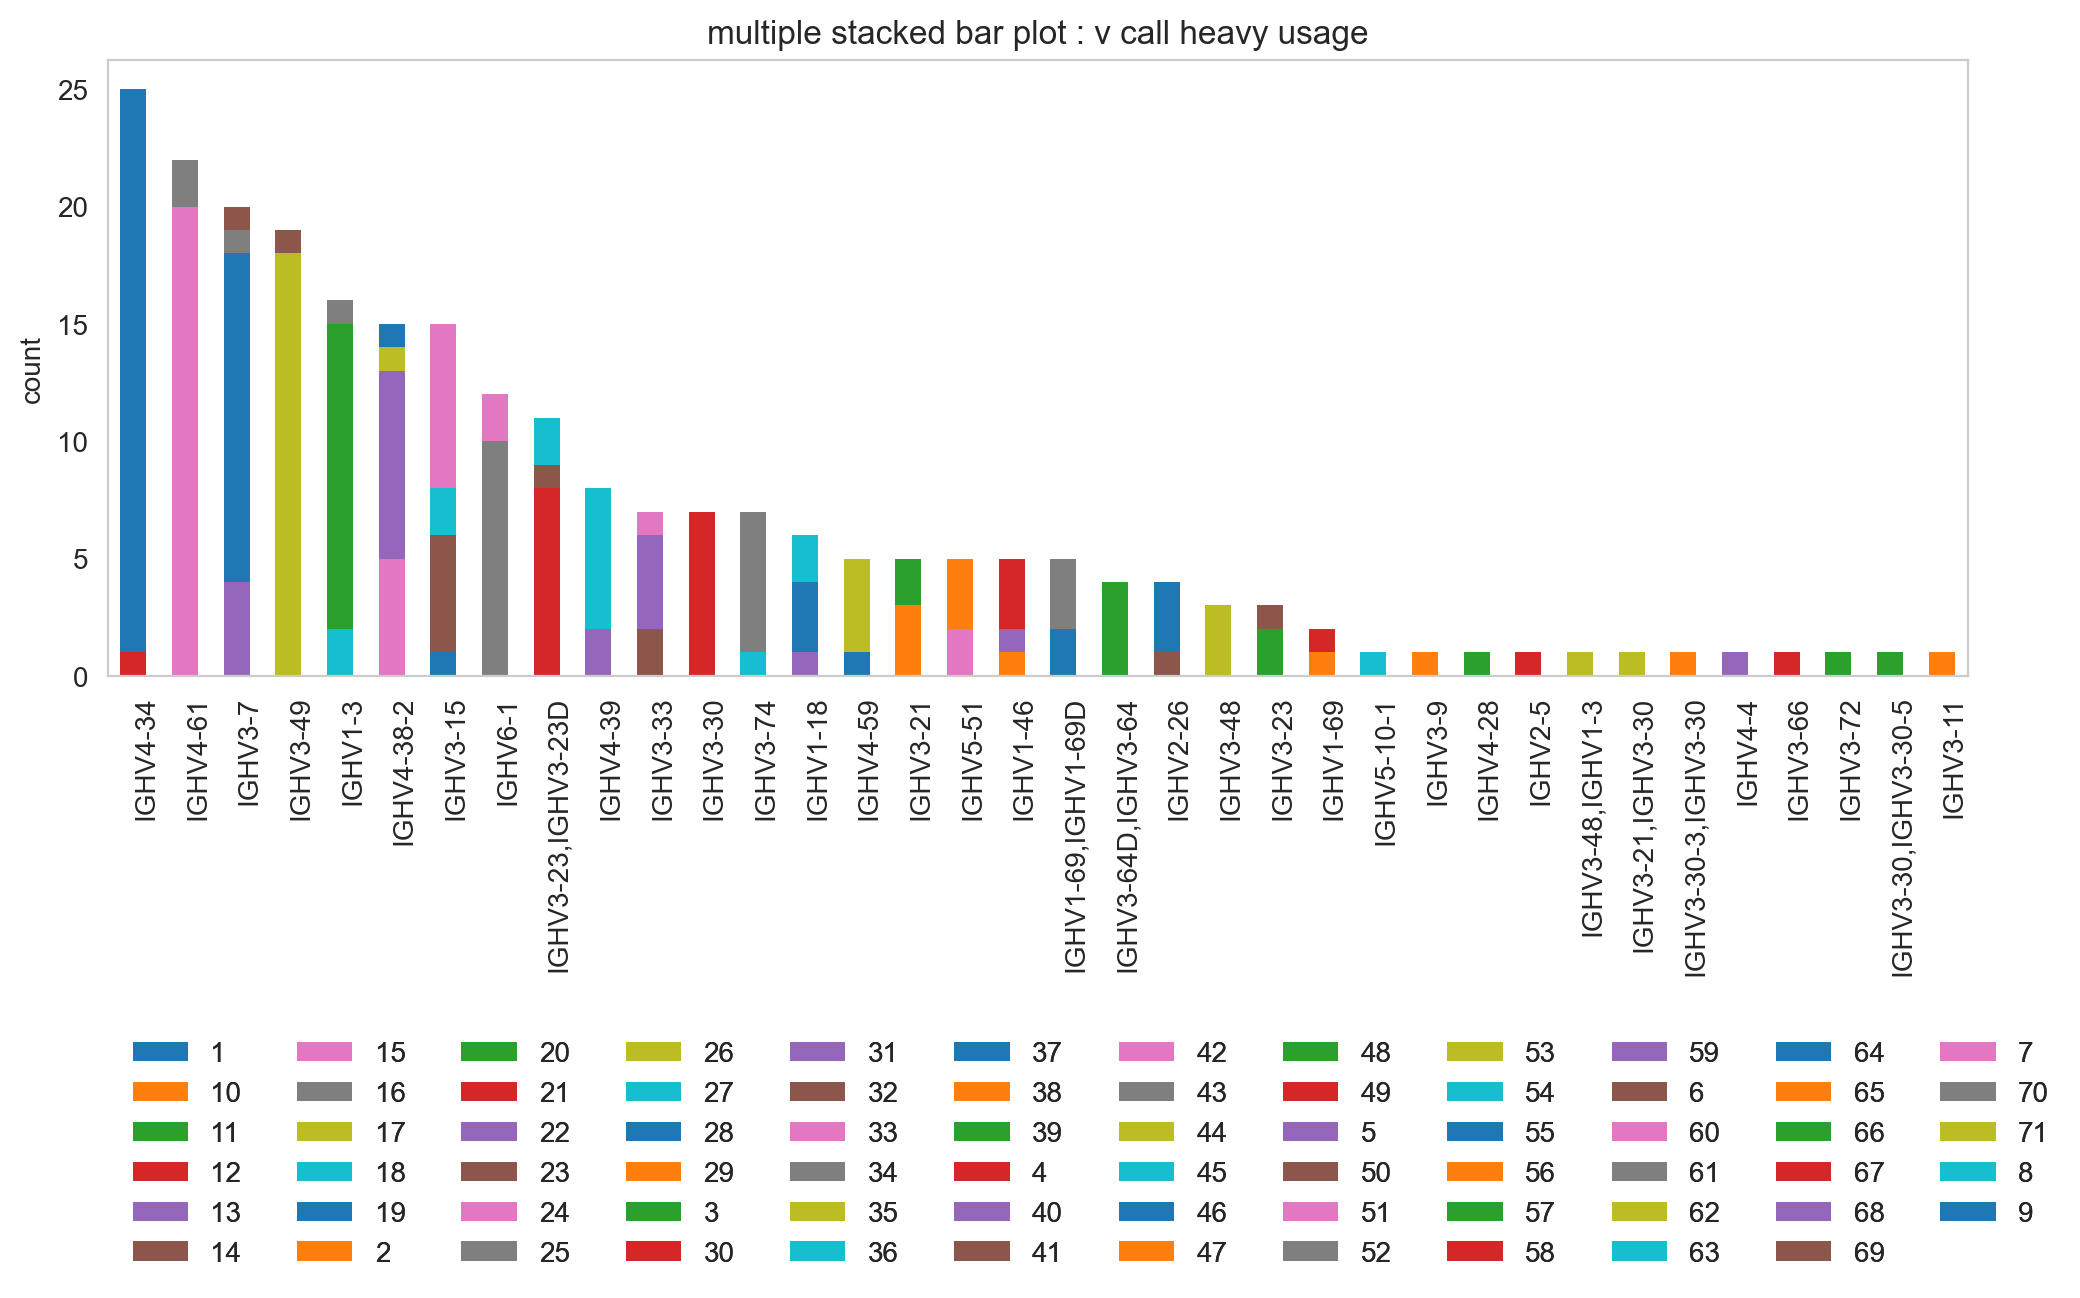

In [47]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'clone_group_id', legend_options = ('lower left', (0, -1), 12))

## *spectratypeplot*
Spectratype plots contain info displaying CDR3 length distribution for specified groups. For this function, the current method only works for `dandelion` objects as it requires access to the contig-indexed *.data* slot.

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13a272390>)

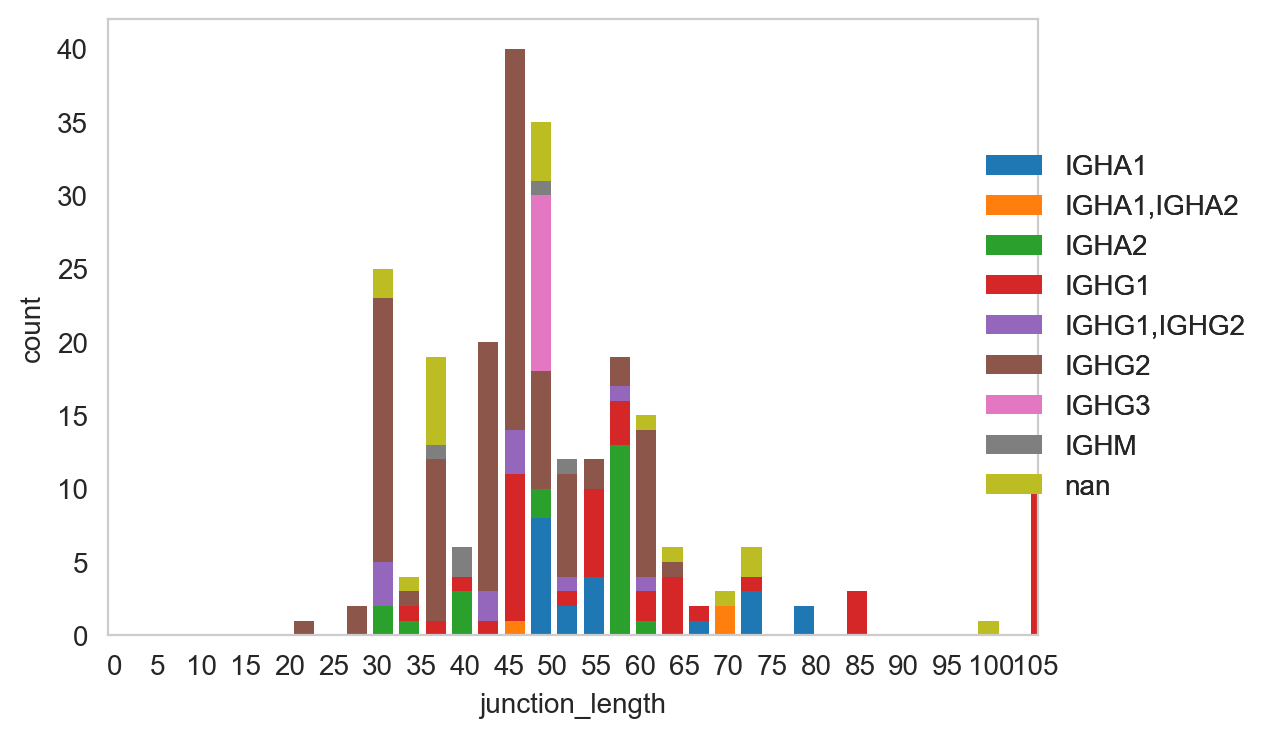

In [48]:
ddl.pl.spectratypeplot(results, variable = 'junction_length', groupby = 'c_call', locus='IGH', width = 2.3)

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13e2e1c50>)

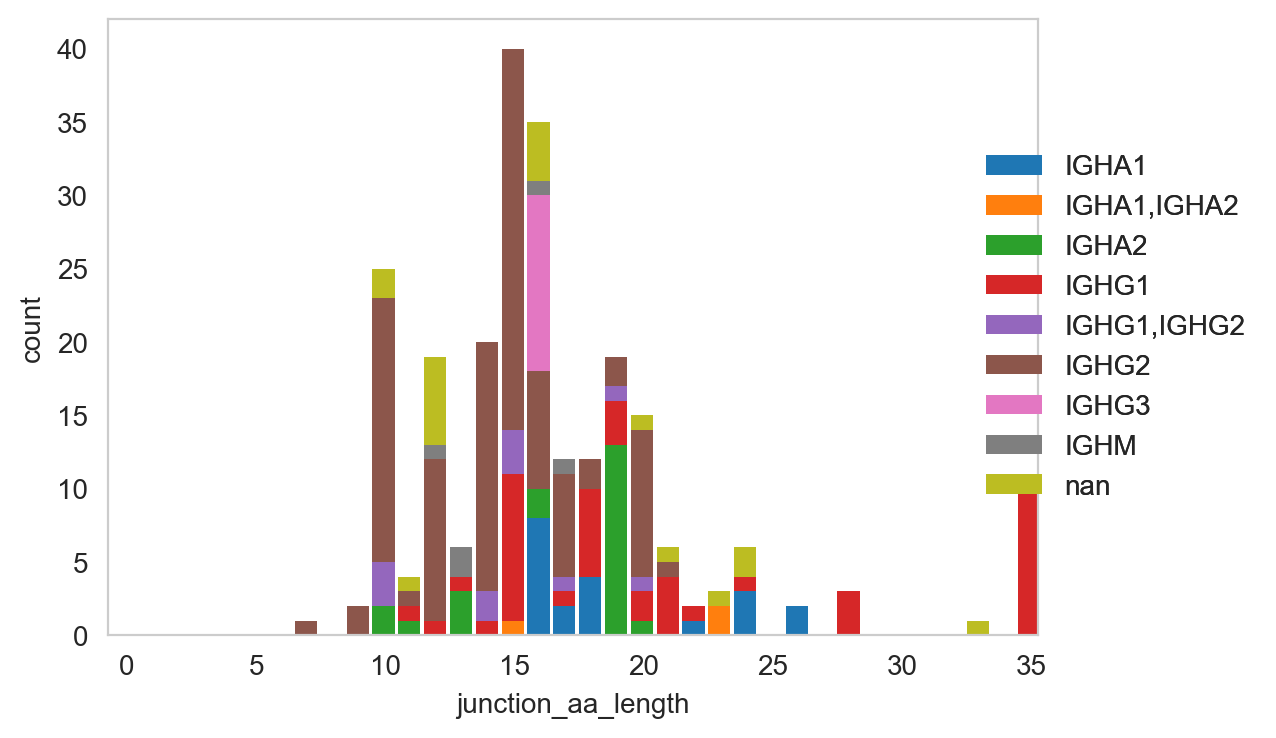

In [49]:
ddl.pl.spectratypeplot(results, variable = 'junction_aa_length', groupby = 'c_call', locus='IGH')

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13ea44910>)

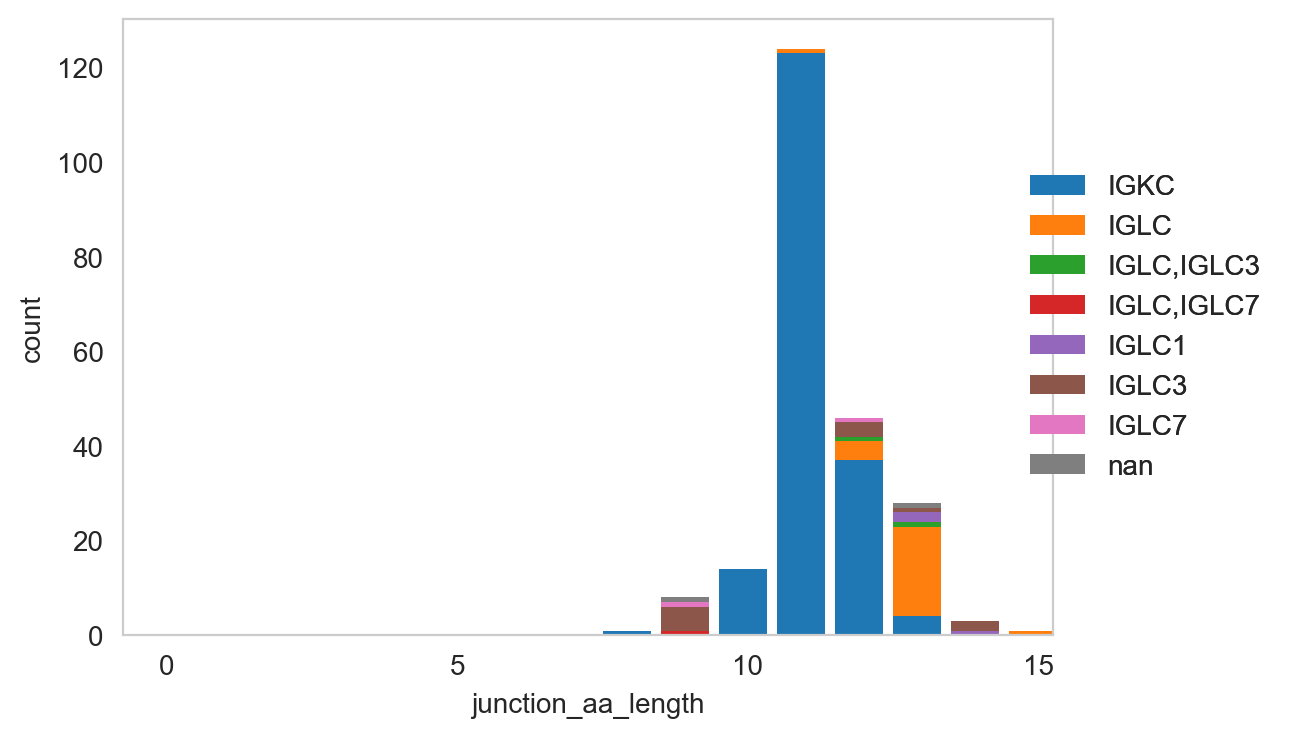

In [50]:
ddl.pl.spectratypeplot(results, variable = 'junction_aa_length', groupby = 'c_call', locus=['IGK','IGL'])

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f0e0390>)

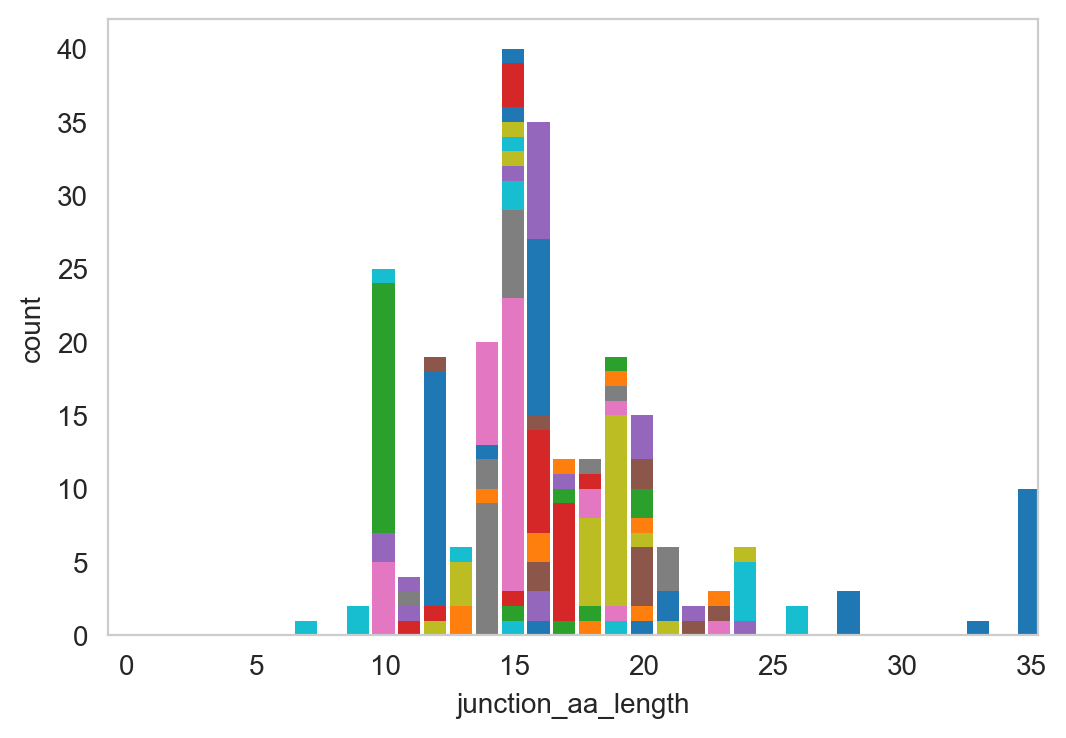

In [51]:
ddl.pl.spectratypeplot(results, variable = 'junction_aa_length', groupby = 'clone_group_id', locus='IGH', hide_legend = True)

That sums it up for now! Let me know if you have any ideas at [kt16@sanger.ac.uk] and I can try and see if i can implement it or we can work something out to collaborate on!